In [1]:
import pandas as pd
import sklearn
import re
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import xgboost as xgb
import math
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier

from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit, GridSearchCV, RandomizedSearchCV, StratifiedGroupKFold, cross_val_score
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, precision_score, recall_score, f1_score, roc_curve, roc_auc_score, precision_recall_curve
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier 
from sklearn.utils import resample
from imblearn.over_sampling import RandomOverSampler, SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.ensemble import BalancedRandomForestClassifier
from IPython.display import display, Markdown
from scipy import stats
from scipy.stats import skew, kurtosis
from xgboost import XGBClassifier
from skopt import BayesSearchCV

In [2]:
display(Markdown("""
# Helper Functions
"""))


# Helper Functions


In [3]:
def analyze_readmission(df, column, fontsize=10):

    # Group by the specified column and readmitted status
    column_counts = df.groupby([column, 'readmitted_new'])['encounter_id'].count().reset_index()
    column_counts.columns = [column, 'readmitted_new', 'count']

    # Calculate total counts
    total_counts = column_counts.groupby(column)['count'].sum().reset_index()
    total_counts.columns = [column, 'total_count']

    # Merge total counts back to the grouped DataFrame
    column_counts = column_counts.merge(total_counts, on=column)

    # Calculate the percentage of readmissions
    column_counts['percentage'] = ((column_counts['count'] / column_counts['total_count']) * 100).round(1)

    filtered_counts = column_counts[column_counts['readmitted_new'] == '<30']

    # Plot the results
    plt.figure(figsize=(10, 6))
    bars = plt.bar(filtered_counts[column], filtered_counts['percentage'], color='skyblue')
    plt.bar(filtered_counts[column], filtered_counts['percentage'], color='skyblue')
    plt.xlabel(column)
    plt.ylabel('Percentage of Readmissions (%)')
    plt.title(f'Percentage of Readmissions (<30) by {column}')
    plt.xticks(rotation=45)
    plt.grid(axis='y')

    for bar, count in zip(bars, filtered_counts['count']):
        yval = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2, yval, f'{yval:.1f}%', ha='center', va='bottom')
        plt.text(bar.get_x() + bar.get_width()/2, 0, f'Tot: {count}', ha='center', va='bottom', color='black', fontsize=fontsize)
        
    # Show the plot
    plt.tight_layout()
    plt.show()


# Split code_range into min_code and max_code
def split_code_range(row):
    code_range = row['code_range']
    min_code, max_code = code_range.split('-')
    
    return pd.Series([min_code, max_code])

# Assign the description based on the range
def get_description(row, df1, column):
    code = str(row[column])

    # Check if the code starts with 'E' or 'V'
    if code.startswith('E') or code.startswith('V'):
        # Filter DataFrame 1 for ranges starting with the same letter
        df_filtered = df1[df1['code_range'].str.startswith(code[0])]
        for _, r in df_filtered.iterrows():
            # Compare the min_code and max_code with the current code
            if r['min_ICD_code'] <= code <= r['max_ICD_code']:
                return r['ICD9_description']
    else:
        # Handle numeric codes including decimals
        try:
            code_float = float(code)  # Convert to float for comparison
            # Filter DataFrame 1 for numeric ranges
            df_filtered = df1[df1['min_ICD_code'].str.replace('.', '').str.isnumeric()]
            for _, r in df_filtered.iterrows():
                min_code_float = float(r['min_ICD_code'])  # Convert min_code to float
                max_code_float = float(r['max_ICD_code'])  # Convert max_code to float
                if min_code_float <= code_float <= max_code_float:
                    return r['ICD9_description']
        except ValueError:
            return None  # If conversion fails, return None

    return None

def on_step(optim_result):
    best_score = -optim_result.fun  # BayesSearchCV minimizes the score, so negate it
    errors.append(best_score)

In [4]:
display(Markdown("""
# Read datasets 
"""))


# Read datasets 


In [5]:
#Read the dataset
df = pd.read_csv("diabetic_data.csv", na_values="?")
ICD_codes = pd.read_csv("ICDCodes.csv")

C:\Users\carlo\AppData\Local\Temp\ipykernel_15732\3445870862.py:2: DtypeWarning: Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("diabetic_data.csv", na_values="?")


In [6]:
# Read the IDS Mapping tables
with open('IDS_mapping.csv', 'r') as f:
    content = f.read()

# Split the content by ",\n" to separate the tables
tables = content.split(",\n")

# Convert each table into a DataFrame
dataframes = []
for table in tables:
    # Clean leading/trailing whitespace
    table = table.strip()
    from io import StringIO
    tempdf = pd.read_csv(StringIO(table))
    dataframes.append(tempdf)

In [7]:
display(Markdown("""
# Dataset preview + general descriptive statistics
"""))


# Dataset preview + general descriptive statistics


In [8]:
# Preview of dataset
df.head(5).T

,0,1,2,3,4
encounter_id,2278392,149190,64410,500364,16680
patient_nbr,8222157,55629189,86047875,82442376,42519267
race,Caucasian,Caucasian,AfricanAmerican,Caucasian,Caucasian
gender,Female,Female,Female,Male,Male
age,[0-10),[10-20),[20-30),[30-40),[40-50)
weight,NaN,NaN,NaN,NaN,NaN
admission_type_id,6,1,1,1,1
discharge_disposition_id,25,1,1,1,1
admission_source_id,1,7,7,7,7
time_in_hospital,1,3,2,2,1


In [9]:
# Descriptive statistics of data
df.describe(include='all').T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
encounter_id,101766.0,NaN,NaN,NaN,165201645.622978,102640295.983458,12522.0,84961194.0,152388987.0,230270887.5,443867222.0
patient_nbr,101766.0,NaN,NaN,NaN,54330400.694947,38696359.346534,135.0,23413221.0,45505143.0,87545949.75,189502619.0
race,99493,5,Caucasian,76099,NaN,NaN,NaN,NaN,NaN,NaN,NaN
gender,101766,3,Female,54708,NaN,NaN,NaN,NaN,NaN,NaN,NaN
age,101766,10,[70-80),26068,NaN,NaN,NaN,NaN,NaN,NaN,NaN
weight,3197,9,[75-100),1336,NaN,NaN,NaN,NaN,NaN,NaN,NaN
admission_type_id,101766.0,NaN,NaN,NaN,2.024006,1.445403,1.0,1.0,1.0,3.0,8.0
discharge_disposition_id,101766.0,NaN,NaN,NaN,3.715642,5.280166,1.0,1.0,1.0,4.0,28.0
admission_source_id,101766.0,NaN,NaN,NaN,5.754437,4.064081,1.0,1.0,7.0,7.0,25.0
time_in_hospital,101766.0,NaN,NaN,NaN,4.395987,2.985108,1.0,2.0,4.0,6.0,14.0


In [10]:
display(Markdown("""
# Missing Data Analysis

- Columns weight, payer_code and medical_specialty have 96.9%, 39.6% and 49.1% of missing values. They were
dropped as there will be no significance in interpolating / filling NAs nor in using them as features.

- Missing values of columns race, diag_1, diag_2 and diag_3 are low and will be dealt with later.

- Missing values of max_glu_seru and A1Cresult happen because the test was not made. For now, it will be assumed that if 
no test was done, then the patient has a normal test result (maybe the doctor did not order the test). However, further
analysis will be performed later.
"""))


# Missing Data Analysis

- Columns weight, payer_code and medical_specialty have 96.9%, 39.6% and 49.1% of missing values. They were
dropped as there will be no significance in interpolating / filling NAs nor in using them as features.

- Missing values of columns race, diag_1, diag_2 and diag_3 are low and will be dealt with later.

- Missing values of max_glu_seru and A1Cresult happen because the test was not made. For now, it will be assumed that if 
no test was done, then the patient has a normal test result (maybe the doctor did not order the test). However, further
analysis will be performed later.


In [11]:
# Check for missing values
missing_count = df.isnull().sum()

# Calculate the percentage of missing values
missing_percentage = ((missing_count / len(df)) * 100).round(1)

# Combine the count and percentage into one DataFrame
missing_summary = pd.DataFrame({
    'Missing Count': missing_count,
    'Missing Percentage': missing_percentage
})

print(missing_summary)

                          Missing Count  Missing Percentage
encounter_id                          0                 0.0
patient_nbr                           0                 0.0
race                               2273                 2.2
gender                                0                 0.0
age                                   0                 0.0
weight                            98569                96.9
admission_type_id                     0                 0.0
discharge_disposition_id              0                 0.0
admission_source_id                   0                 0.0
time_in_hospital                      0                 0.0
payer_code                        40256                39.6
medical_specialty                 49949                49.1
num_lab_procedures                    0                 0.0
num_procedures                        0                 0.0
num_medications                       0                 0.0
number_outpatient                     0 

In [12]:
# Drop columns weight, payer_code and medical_specialty
df = df.drop(['weight','payer_code','medical_specialty'], axis = 1)

In [13]:
display(Markdown("""
# Patients with more than one visit

##### There are a couple of ways to deal with patients with multiple visits.
        1) Aggregate data by patient.
        2) Time series model (using past data of patients as features).
        3) Keep each record as independent + stratified splitting (keeping same patients in either training or testing data).
        4) Use only the first visit of the patient
        5) Use only the last visit of the patient
        6) Use all records

##### Some of the considerations to choose a solution:
        1) Data leakage (knowing that a patient came back). This is highly undesirable as it may skew accuracy results in production. 
        2) Unbalanced dataset towards repeated patients (23.45% of patients have 2 or more visits)

##### In a real case scenario, the doctor would want to know the chance of a patient being readmitted if he decided to discharge the patient. The doctor would have all the information of the patient, including the previous visits. Hence, the approach that should be taken is to use only the last record and use previous records (if available) to create time series features (i.e. number of previous visits, test showed "x" result at least once, etc)  

##### There is no date column. However, there is an encounter_id column. It could be assumed that the order of the visits of the same patient can be determined by the encounter_id. The last visit would correspond to the highest encounter_id value. 

##### The problem with the above approach is that it further imbalances the dataset. The original dataset has around 11% True values (readmitted in less than 30 days). However, after only selecting last visits, the True values decrease to around 4%. If only first visit is selected the true values are around 8%. Because of this, all patients visits will be used and then stratified spliting by patient so that a single patient is only in the train or test set.
"""))


# Patients with more than one visit

##### There are a couple of ways to deal with patients with multiple visits.
        1) Aggregate data by patient.
        2) Time series model (using past data of patients as features).
        3) Keep each record as independent + stratified splitting (keeping same patients in either training or testing data).
        4) Use only the first visit of the patient
        5) Use only the last visit of the patient
        6) Use all records

##### Some of the considerations to choose a solution:
        1) Data leakage (knowing that a patient came back). This is highly undesirable as it may skew accuracy results in production. 
        2) Unbalanced dataset towards repeated patients (23.45% of patients have 2 or more visits)

##### In a real case scenario, the doctor would want to know the chance of a patient being readmitted if he decided to discharge the patient. The doctor would have all the information of the patient, including the previous visits. Hence, the approach that should be taken is to use only the last record and use previous records (if available) to create time series features (i.e. number of previous visits, test showed "x" result at least once, etc)  

##### There is no date column. However, there is an encounter_id column. It could be assumed that the order of the visits of the same patient can be determined by the encounter_id. The last visit would correspond to the highest encounter_id value. 

##### The problem with the above approach is that it further imbalances the dataset. The original dataset has around 11% True values (readmitted in less than 30 days). However, after only selecting last visits, the True values decrease to around 4%. If only first visit is selected the true values are around 8%. Because of this, all patients visits will be used and then stratified spliting by patient so that a single patient is only in the train or test set.


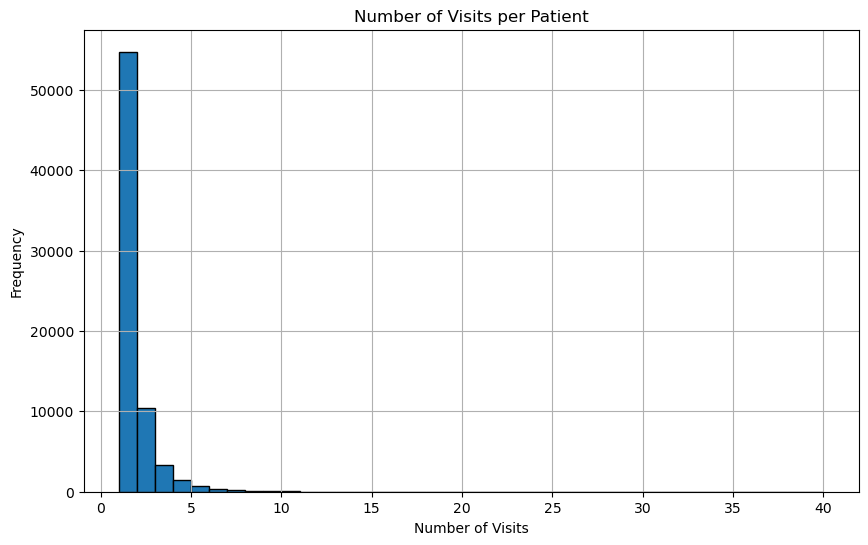

Number of patients with 2 or more visits: 16773
Percentage of patients with 2 or more visits: 23.45%
Number of unique patients: 71518


In [14]:
# Group by 'patient_nbr' to get the number of visits per patient
visit_counts = df['patient_nbr'].value_counts()

# Create a histogram of the number of visits per patient
plt.figure(figsize=(10, 6))
plt.hist(visit_counts, bins=range(1, visit_counts.max() + 1), edgecolor='black')
plt.title('Number of Visits per Patient')
plt.xlabel('Number of Visits')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

# Calculate the number and percentage of patients with 2 or more visits
patients_2_or_more = visit_counts[visit_counts >= 2].count()
total_patients = visit_counts.count()
percentage_2_or_more = (patients_2_or_more / total_patients) * 100

print(f"Number of patients with 2 or more visits: {patients_2_or_more}")
print(f"Percentage of patients with 2 or more visits: {percentage_2_or_more:.2f}%")
print(f"Number of unique patients: {total_patients}")

In [15]:
# Only last record of visit (Not used because it further creates an imbalance)
df_unique_patients_max = df.loc[df.groupby('patient_nbr')['encounter_id'].idxmax()].copy(deep=True)

# Only first record of visit (Not used because it further creates an imbalance)
df_unique_patients_min = df.loc[df.groupby('patient_nbr')['encounter_id'].idxmin()].copy(deep=True)

#Use all records and then use stratified group splitting so that patients are either on the train or test set (and avoid data leckage). 
df_unique_patients = df.copy(deep=True)

In [16]:
print("Using last visit")
print(df_unique_patients_max.readmitted.value_counts())
print(" ")

print("Using first visit")
print(df_unique_patients_min.readmitted.value_counts())
print(" ")

print("Using all visits")
print(df_unique_patients.readmitted.value_counts())

Using last visit
readmitted
NO     54374
>30    13920
<30     3224
Name: count, dtype: int64
 
Using first visit
readmitted
NO     42985
>30    22240
<30     6293
Name: count, dtype: int64
 
Using all visits
readmitted
NO     54864
>30    35545
<30    11357
Name: count, dtype: int64


In [17]:
display(Markdown("""
# Data exploration / Feature Engineering

##### Readmitted (Target variable):
Current column has three values: No, >30 and <30. The goal is to "determine the early readmission of the patient within 30 days of discharge."
Since there is no difference between No and >30 (as per the goal), they will be combined. This also has the added benefit of transforming the 
problem from a multiclass classification task to a binary classification task. 

##### Race:
Data was grouped by patient number to fill out NAs of race the same patient. 125 patients (0.2%) have multiple races (changed between visits). 
The race of the last visit was assumed as the valid one. After this, the number of NAs was reduced to 1850 (2.6%). The missing values were
assigned "Unknown". Afterwards, one-hot encoding was applied, making the Unknowns as part of "Others". The reason to apply one hot encoding was
that race is a nominal variable (no order between the categories White, Asian, Black, etc.). The downside of applying one-hot encoding is that it 
will increase the dimensionality of the model. This suggest that tree based models should be considered. 

##### Gender:
2 patients have multiple genders (changed between visits). The gender of the last visit was assumed as the valid one. Three
patients have Unknown/Invalid. One hot encoding was applied creating a column gender_Female, which made these Unknown values "Male"

##### Age:
There are 10 age groups and some of them [0-10) and [10-20) account for less than 1% of the data. However, combining age  brackets is not 
recommended as readmission in less than 30 days (<30) varies (0.7% for [0-10) vs 5.6% for [80-90)). One hot encoding was performed.

##### Admission type ID:
Categories were combined in three. First is Emergency/Urgent, sencond is Elective and Third is no data. Newborn and Trauma Center have
4 and 19 records, which is not statistically significant. One hot encoding was applied.

##### Discharge Disposition ID:
Expired patients were filtered out as the chance of being readmitted is 0 (they are dead). Then, remaining categories were classified in
Discharged_care_facility, Discharged_home, Discharged_hospital, Discharged_longterm and Not Mapped. One hot encoding was applied.  

##### Admission source ID:
Categories were classified in Emergency room, referal and transfer. One hot encoding was applied. 

##### Numeric columns 'time_in_hospital', 'num_lab_procedures', 'num_procedures', 'num_medications', 'number_outpatient', 'number_emergency', 'number_inpatient' and number_diagnoses:
Created boxplots, violin plots, historgrams annd measured skewness and kurtosis. All variables except num_lab_procedures have skewness 
above 1 (right skewed). About half of them have a high positive kurtosis (long tails). This further suggest that tree based models may be the
correct approach since they are generally not affected by high kurtosis and right skewed data.

##### Diagnosis 1, 2 and 3:
Descriptions were obtained for interpretability. Diseases with the highest readmission within 30 days are blood, Injury_Posion and Supplementary
factors (V). We had seen before that these columns had some missing values 17 (0.02%), 290 (0.4%) and 1144 (1.6%), which are low. One hot encoding of
multiple columns into a single set of categorical columns was made. 

##### max_glu_serum:
Values above 200 indicate diabetes. 200 and 300 were merged and then the column one hot encoded.

##### A1Cresult:
Values above 6.5 indicate diabetes. 7 and 8  were merged and then column one hot encoded.

##### Up, down, Steady and No columns metformin, repaglinide, nateglinide, chlorpropamide, glimepiride, acetohexamide, glipizide, glyburide, tolbutamide, pioglitazone, rosiglitazone, acarbose, miglitol, troglitazone, tolazamide, examide, citoglipton, insulin, glyburide-metformin, glipizide-metformin, glimepiride-pioglitazone, metformin-rosiglitazone, metformin-pioglitazone:
Columns where value was mostly no >99% were dropped. New features were created to count the number of prescriptions and changes. 

##### Change and diabetesMed
One hot encoded.

##### Time series features
Did not use as the whole dataset was used for training.

"""))


# Data exploration / Feature Engineering

##### Readmitted (Target variable):
Current column has three values: No, >30 and <30. The goal is to "determine the early readmission of the patient within 30 days of discharge."
Since there is no difference between No and >30 (as per the goal), they will be combined. This also has the added benefit of transforming the 
problem from a multiclass classification task to a binary classification task. 

##### Race:
Data was grouped by patient number to fill out NAs of race the same patient. 125 patients (0.2%) have multiple races (changed between visits). 
The race of the last visit was assumed as the valid one. After this, the number of NAs was reduced to 1850 (2.6%). The missing values were
assigned "Unknown". Afterwards, one-hot encoding was applied, making the Unknowns as part of "Others". The reason to apply one hot encoding was
that race is a nominal variable (no order between the categories White, Asian, Black, etc.). The downside of applying one-hot encoding is that it 
will increase the dimensionality of the model. This suggest that tree based models should be considered. 

##### Gender:
2 patients have multiple genders (changed between visits). The gender of the last visit was assumed as the valid one. Three
patients have Unknown/Invalid. One hot encoding was applied creating a column gender_Female, which made these Unknown values "Male"

##### Age:
There are 10 age groups and some of them [0-10) and [10-20) account for less than 1% of the data. However, combining age  brackets is not 
recommended as readmission in less than 30 days (<30) varies (0.7% for [0-10) vs 5.6% for [80-90)). One hot encoding was performed.

##### Admission type ID:
Categories were combined in three. First is Emergency/Urgent, sencond is Elective and Third is no data. Newborn and Trauma Center have
4 and 19 records, which is not statistically significant. One hot encoding was applied.

##### Discharge Disposition ID:
Expired patients were filtered out as the chance of being readmitted is 0 (they are dead). Then, remaining categories were classified in
Discharged_care_facility, Discharged_home, Discharged_hospital, Discharged_longterm and Not Mapped. One hot encoding was applied.  

##### Admission source ID:
Categories were classified in Emergency room, referal and transfer. One hot encoding was applied. 

##### Numeric columns 'time_in_hospital', 'num_lab_procedures', 'num_procedures', 'num_medications', 'number_outpatient', 'number_emergency', 'number_inpatient' and number_diagnoses:
Created boxplots, violin plots, historgrams annd measured skewness and kurtosis. All variables except num_lab_procedures have skewness 
above 1 (right skewed). About half of them have a high positive kurtosis (long tails). This further suggest that tree based models may be the
correct approach since they are generally not affected by high kurtosis and right skewed data.

##### Diagnosis 1, 2 and 3:
Descriptions were obtained for interpretability. Diseases with the highest readmission within 30 days are blood, Injury_Posion and Supplementary
factors (V). We had seen before that these columns had some missing values 17 (0.02%), 290 (0.4%) and 1144 (1.6%), which are low. One hot encoding of
multiple columns into a single set of categorical columns was made. 

##### max_glu_serum:
Values above 200 indicate diabetes. 200 and 300 were merged and then the column one hot encoded.

##### A1Cresult:
Values above 6.5 indicate diabetes. 7 and 8  were merged and then column one hot encoded.

##### Up, down, Steady and No columns metformin, repaglinide, nateglinide, chlorpropamide, glimepiride, acetohexamide, glipizide, glyburide, tolbutamide, pioglitazone, rosiglitazone, acarbose, miglitol, troglitazone, tolazamide, examide, citoglipton, insulin, glyburide-metformin, glipizide-metformin, glimepiride-pioglitazone, metformin-rosiglitazone, metformin-pioglitazone:
Columns where value was mostly no >99% were dropped. New features were created to count the number of prescriptions and changes. 

##### Change and diabetesMed
One hot encoded.

##### Time series features
Did not use as the whole dataset was used for training.



In [18]:
#Create new target variable to determine readmitted patients within 30 days (Binary problem)
df_unique_patients.insert(len(df_unique_patients.columns), 'readmitted_new', np.where(df_unique_patients.readmitted.isin(['>30', 'NO']), 'No', '<30'))

In [19]:
# Sort by 'patient_nbr' and 'encounter_id' in ascending order
df_sorted = df.sort_values(by=['patient_nbr', 'encounter_id'])

# Forward fill the 'race' column within each 'patient_nbr' group
df_sorted['race'] = df_sorted.groupby('patient_nbr')['race'].ffill()

# Now, for each patient, select the row with the highest 'encounter_id'
df_unique_race = df_sorted.loc[df_sorted.groupby('patient_nbr')['encounter_id'].idxmax(), ['patient_nbr', 'encounter_id', 'race']].copy(deep=True)

# Rename and Join the new race column
df_unique_race.rename(columns = {'race': 'race_cleaned'}, inplace = True)
df_unique_patients = df_unique_patients.merge(df_unique_race, on = ['patient_nbr', 'encounter_id'], how = 'left', validate = 'm:1')

# Fill NA values with 'Unknown'
df_unique_patients.fillna({'race_cleaned': 'Unknown'}, inplace=True)

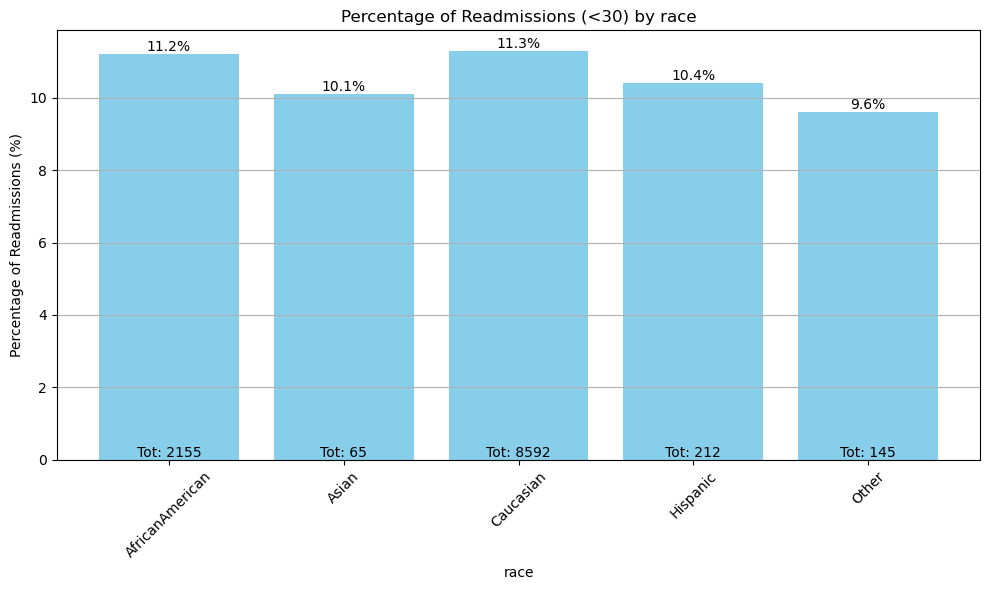

In [20]:
# Readmission by race
analyze_readmission(df_unique_patients, 'race')

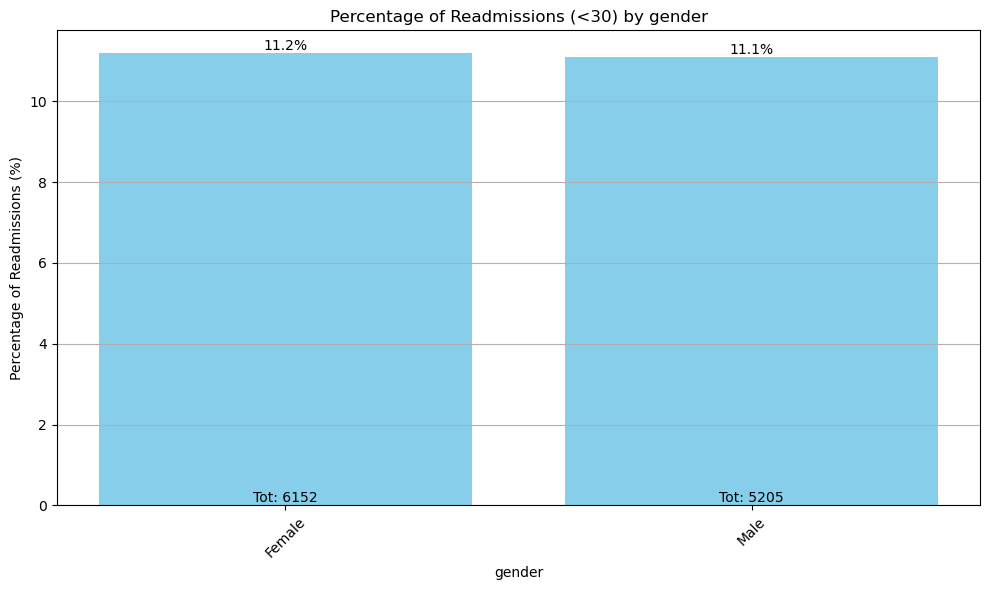

In [21]:
# Readmission by gender
analyze_readmission(df_unique_patients, 'gender')

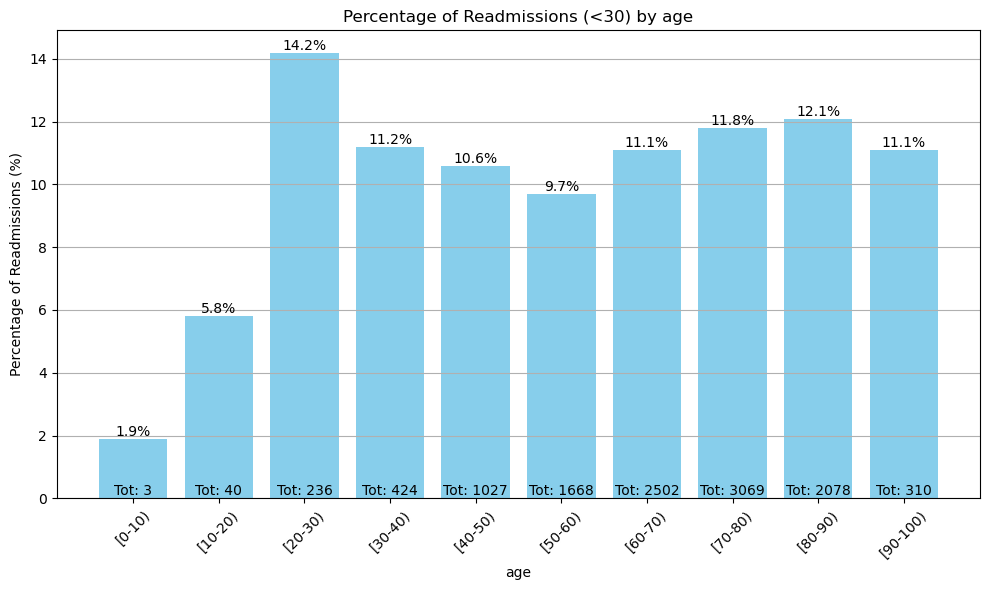

In [22]:
# Readmission by age
analyze_readmission(df_unique_patients, 'age')

In [23]:
# Merge the descriptions of admision ID
dataframes[0].columns = ['admission_type_id', 'admission_description']
df_unique_patients = df_unique_patients.merge(dataframes[0], on='admission_type_id', how='left', validate='m:1')

In [24]:
# Clasify admission ID in Emergency, Elective (non emergency) and No Data
df_unique_patients.loc[df_unique_patients.admission_description.isin(['Urgent']), 'admission_description'] = 'Emergency'
df_unique_patients.loc[df_unique_patients.admission_description.isin(['Not Available', 'Not Mapped', 'Trauma Center', 'Newborn']), 'admission_description'] = 'No Data'
df_unique_patients.loc[df_unique_patients.admission_description.isna(), 'admission_description'] = 'No Data'

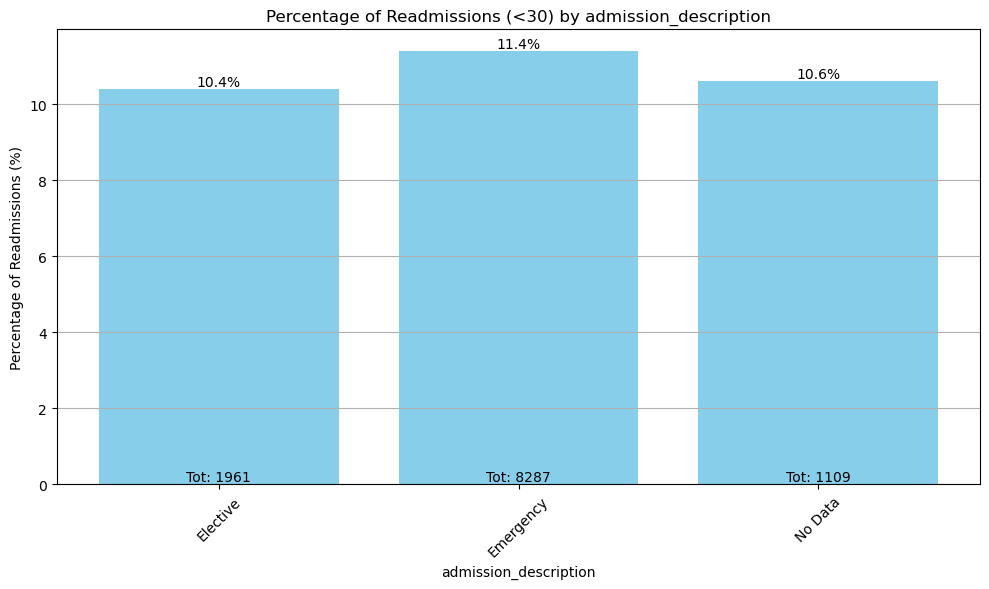

In [25]:
# Readmission by admission
analyze_readmission(df_unique_patients, 'admission_description')

In [26]:
# Merge the descriptions of discharge_disposition_id
dataframes[1].columns = ['discharge_disposition_id', 'discharge_description']
df_unique_patients = df_unique_patients.merge(dataframes[1], on='discharge_disposition_id', how='left', validate='m:1')

In [27]:
# Filter dead patients
dead_patients = ['Expired at home. Medicaid only, hospice.', 'Expired', 'Expired in a medical facility. Medicaid only, hospice.']
df_unique_patients = df_unique_patients.loc[~df_unique_patients.discharge_description.isin(dead_patients), :]

In [28]:
# Clasify discharge ID
Discharged_care_facility = ['Discharged/transferred to ICF', 'Discharged/transferred to SNF',
                            'Discharged/transferred to a nursing facility certified under Medicaid but not certified under Medicare.',
                            'Discharged/transferred to another short term hospital']

Discharged_home = ['Discharged to home', 'Discharged/transferred to home under care of Home IV provider', 'Hospice / home',
                   'Hospice / medical facility', 'Discharged/transferred to home with home health service']

Discharged_hospital = ['Still patient or expected to return for outpatient services', 'Admitted as an inpatient to this hospital',
                       'Discharged/transferred to another rehab fac including rehab units of a hospital .', 
                       'Discharged/transferred within this institution to Medicare approved swing bed',
                       'Discharged/transferred/referred to a psychiatric hospital of psychiatric distinct part unit of a hospital',
                       'Discharged/transferred to another type of inpatient care institution']

Discharged_longterm = ['Discharged/transferred to a long term care hospital.', 'Discharged/transferred to a federal health care facility.',
                       'Discharged/transferred/referred to this institution for outpatient services',
                       'Discharged/transferred/referred another institution for outpatient services',
                       'Neonate discharged to another hospital for neonatal aftercare']       

df_unique_patients.loc[df_unique_patients.discharge_description.isin(Discharged_care_facility), 'discharge_description'] = 'Care_Facility'
df_unique_patients.loc[df_unique_patients.discharge_description.isin(Discharged_home), 'discharge_description'] = 'Home'
df_unique_patients.loc[df_unique_patients.discharge_description.isin(Discharged_hospital), 'discharge_description'] = 'Hospital'
df_unique_patients.loc[df_unique_patients.discharge_description.isin(Discharged_longterm), 'discharge_description'] = 'Long_Term'

df_unique_patients.loc[df_unique_patients.discharge_description.isna(), 'discharge_description'] = 'Not_Mapped'
df_unique_patients.loc[df_unique_patients.discharge_description == 'Not Mapped', 'discharge_description'] = 'Not_Mapped'

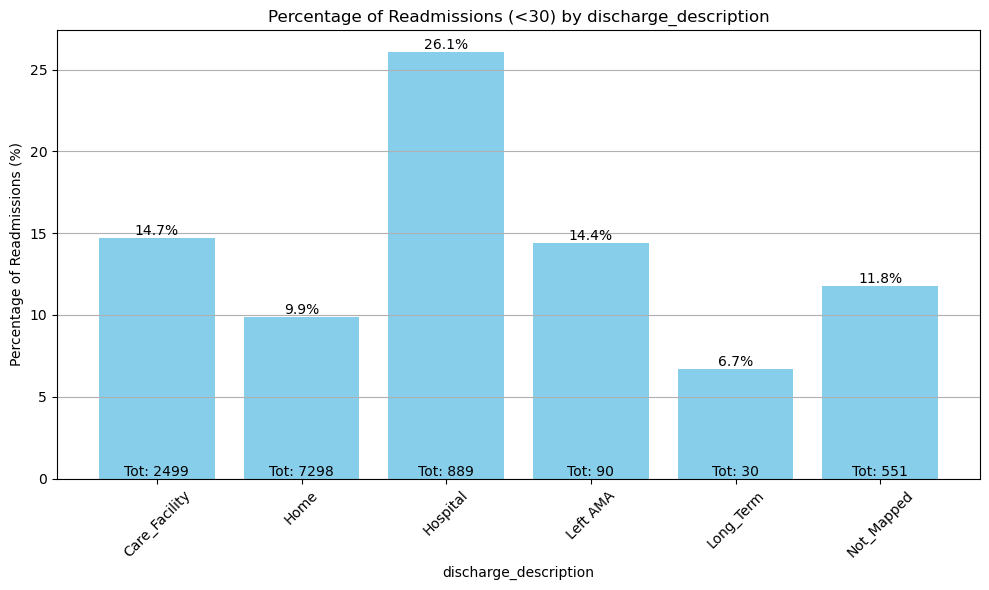

In [29]:
# Readmission by discharge
analyze_readmission(df_unique_patients, 'discharge_description')

In [30]:
# Merge the descriptions of admision source ID
dataframes[2].columns = ['admission_source_id', 'admission_source_description']
df_unique_patients = df_unique_patients.merge(dataframes[2], on='admission_source_id', how='left', validate='m:1')

In [31]:
# Clasify admission_source ID
Admission_referal = ['Clinic Referral', 'HMO Referral', 'Physician Referral']

Admission_transfer = ['Transfer from a hospital', 'Transfer from a Skilled Nursing Facility (SNF)', 'Transfer from critial access hospital',
                      'Transfer from another health care facility', 'Discharged/transferred to home with home health service',
                      'Transfer from hospital inpt/same fac reslt in a sep claim', 'Transfer from Ambulatory Surgery Center']

Admission_other = ['Court/Law Enforcement', 'Extramural Birth', 'Normal Delivery', 'Sick Baby']

df_unique_patients['admission_source_description'] = df_unique_patients['admission_source_description'].str.lstrip()

df_unique_patients.loc[df_unique_patients.admission_source_description.isin(Admission_referal), 'admission_source_description'] = 'Referal'
df_unique_patients.loc[df_unique_patients.admission_source_description.isin(Admission_transfer), 'admission_source_description'] = 'Transfer'
df_unique_patients.loc[df_unique_patients.admission_source_description.isin(Admission_other), 'admission_source_description'] = 'Other'

df_unique_patients.loc[df_unique_patients.admission_source_description == ' Emergency Room', 'admission_source_description'] = 'Emergency_Room'
df_unique_patients.loc[df_unique_patients.admission_source_description.isna(), 'admission_source_description'] = 'Not_Mapped'
df_unique_patients.loc[df_unique_patients.admission_source_description == 'Not Mapped', 'admission_source_description'] = 'Not_Mapped'
df_unique_patients.loc[df_unique_patients.admission_source_description == 'Not Available', 'admission_source_description'] = 'Not_Mapped'

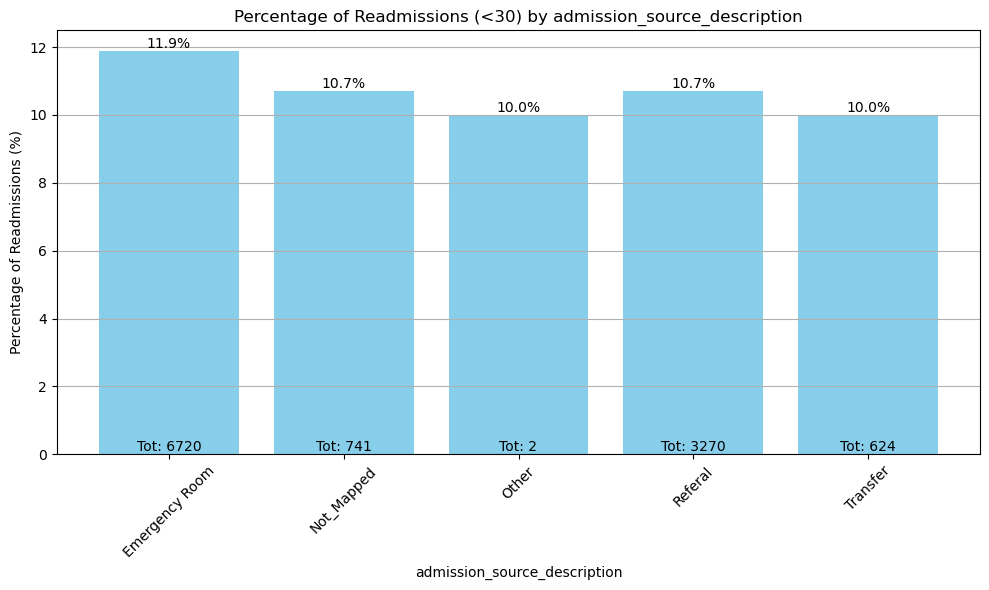

In [32]:
# Readmission by admission_source
analyze_readmission(df_unique_patients, 'admission_source_description')

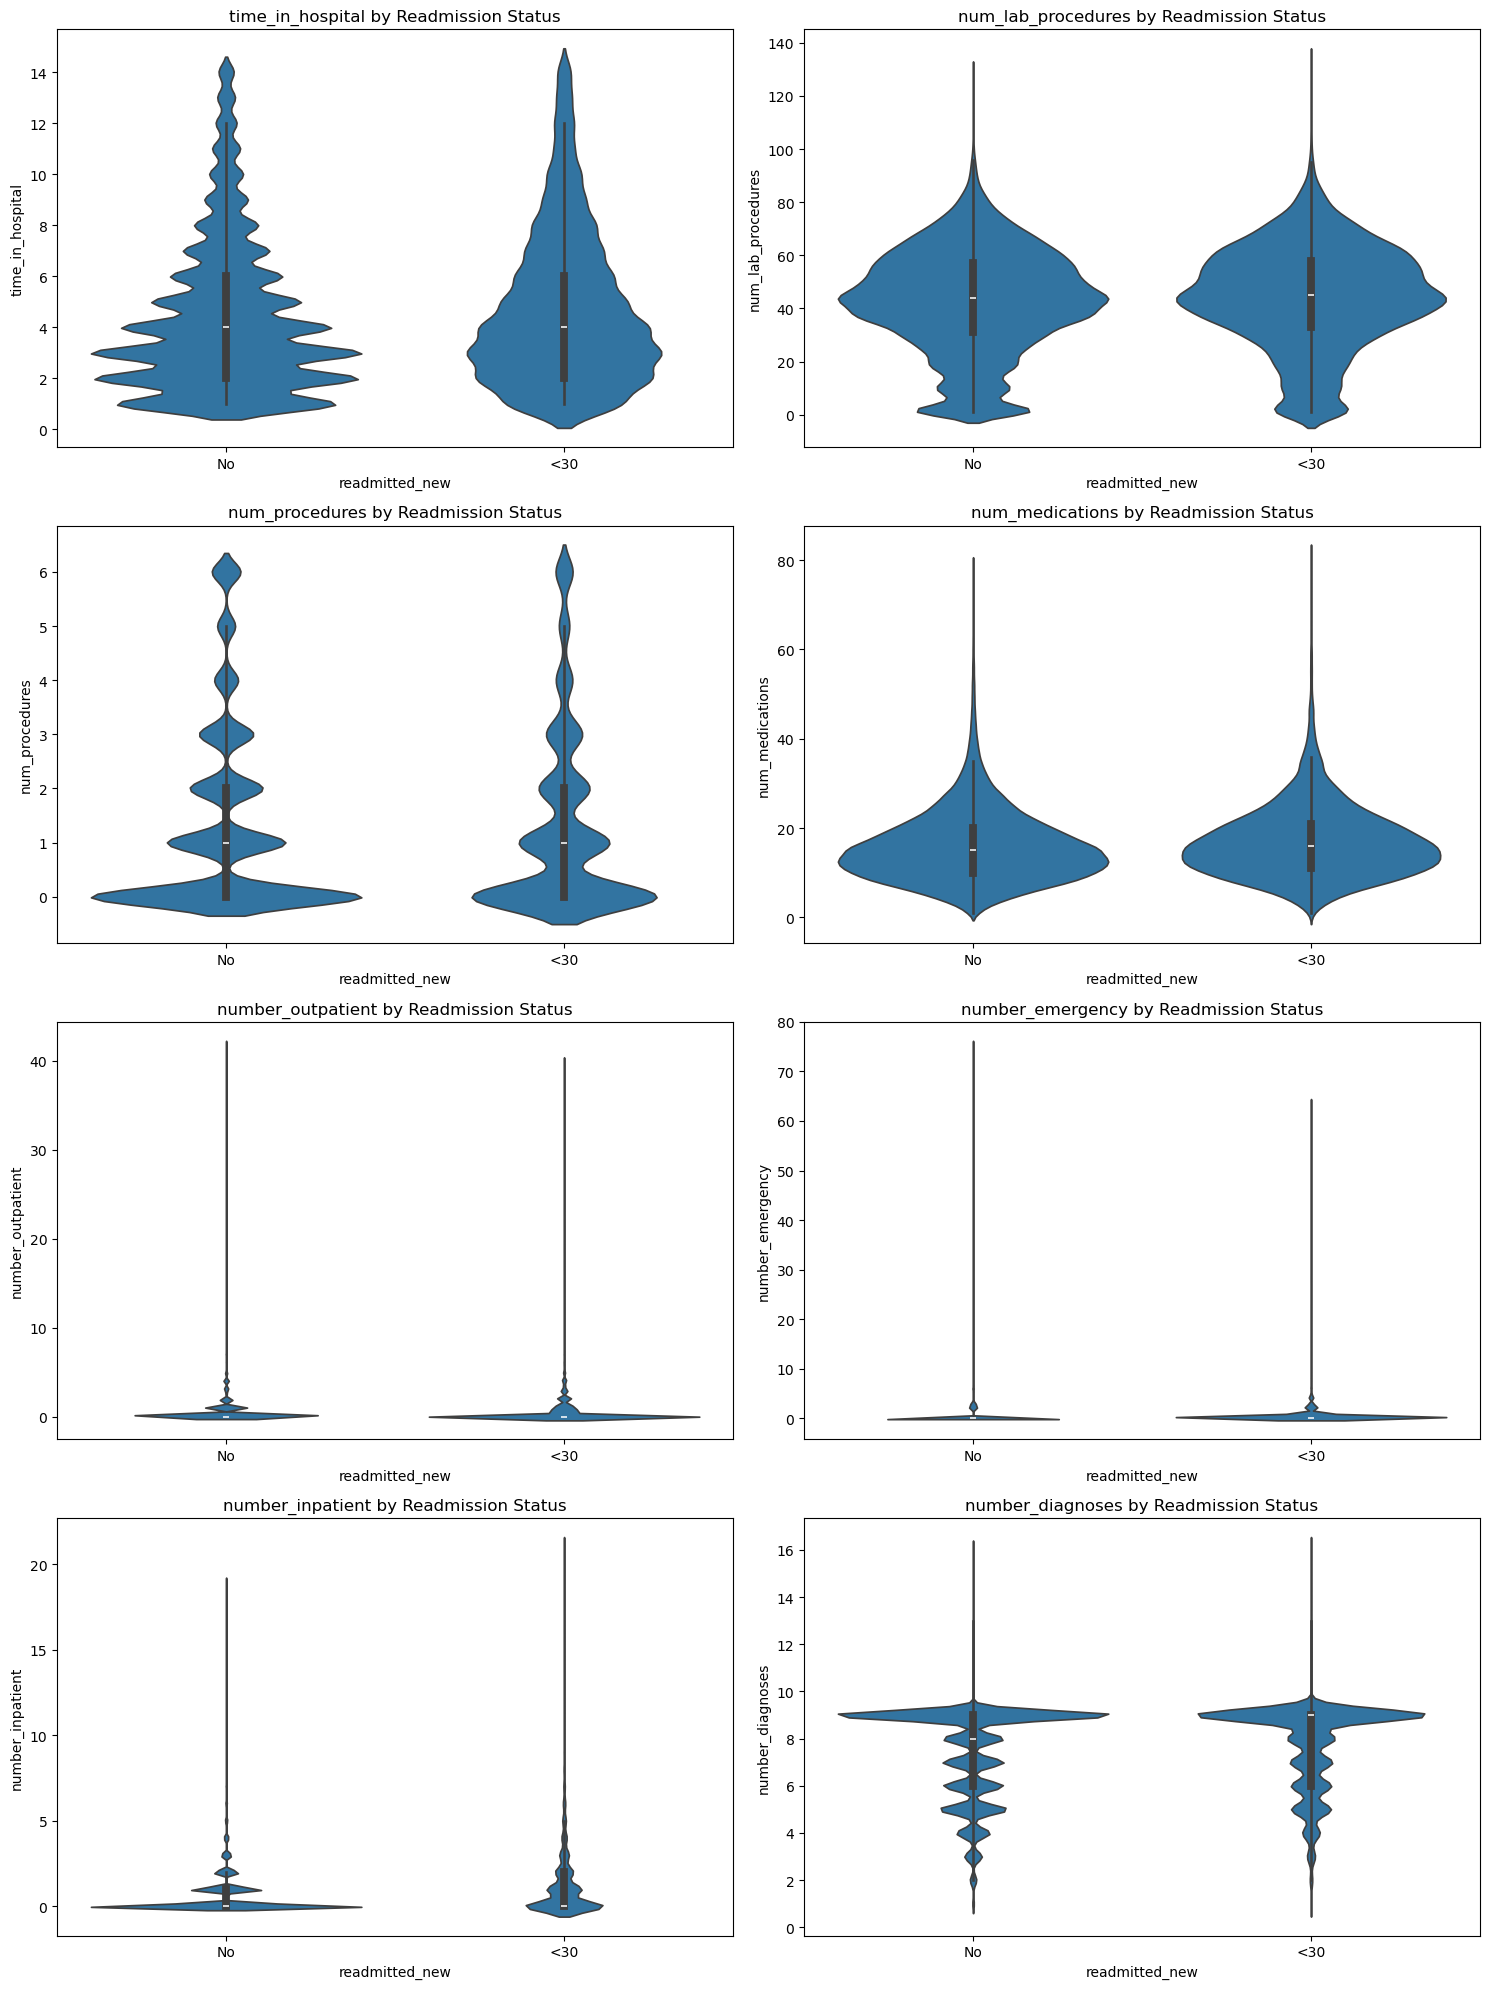

In [33]:
# Review distribution properties of several numerical features. 

# List of columns to plot
columns_to_plot = ['time_in_hospital', 'num_lab_procedures', 'num_procedures', 'num_medications', 
                   'number_outpatient', 'number_emergency', 'number_inpatient', 'number_diagnoses']

# Violin plots

# Set up the figure and axes
fig, axes = plt.subplots(nrows=math.ceil(len(columns_to_plot)/2), ncols=2, figsize=(15, 20))

# Flatten axes array for easier iteration
axes = axes.flatten()

# Create a violin plot for each column
for i, column in enumerate(columns_to_plot):
    sns.violinplot(x='readmitted_new', y=column, data=df_unique_patients, ax=axes[i])
    axes[i].set_title(f'{column} by Readmission Status')

# Adjust the layout
plt.tight_layout()
plt.show()

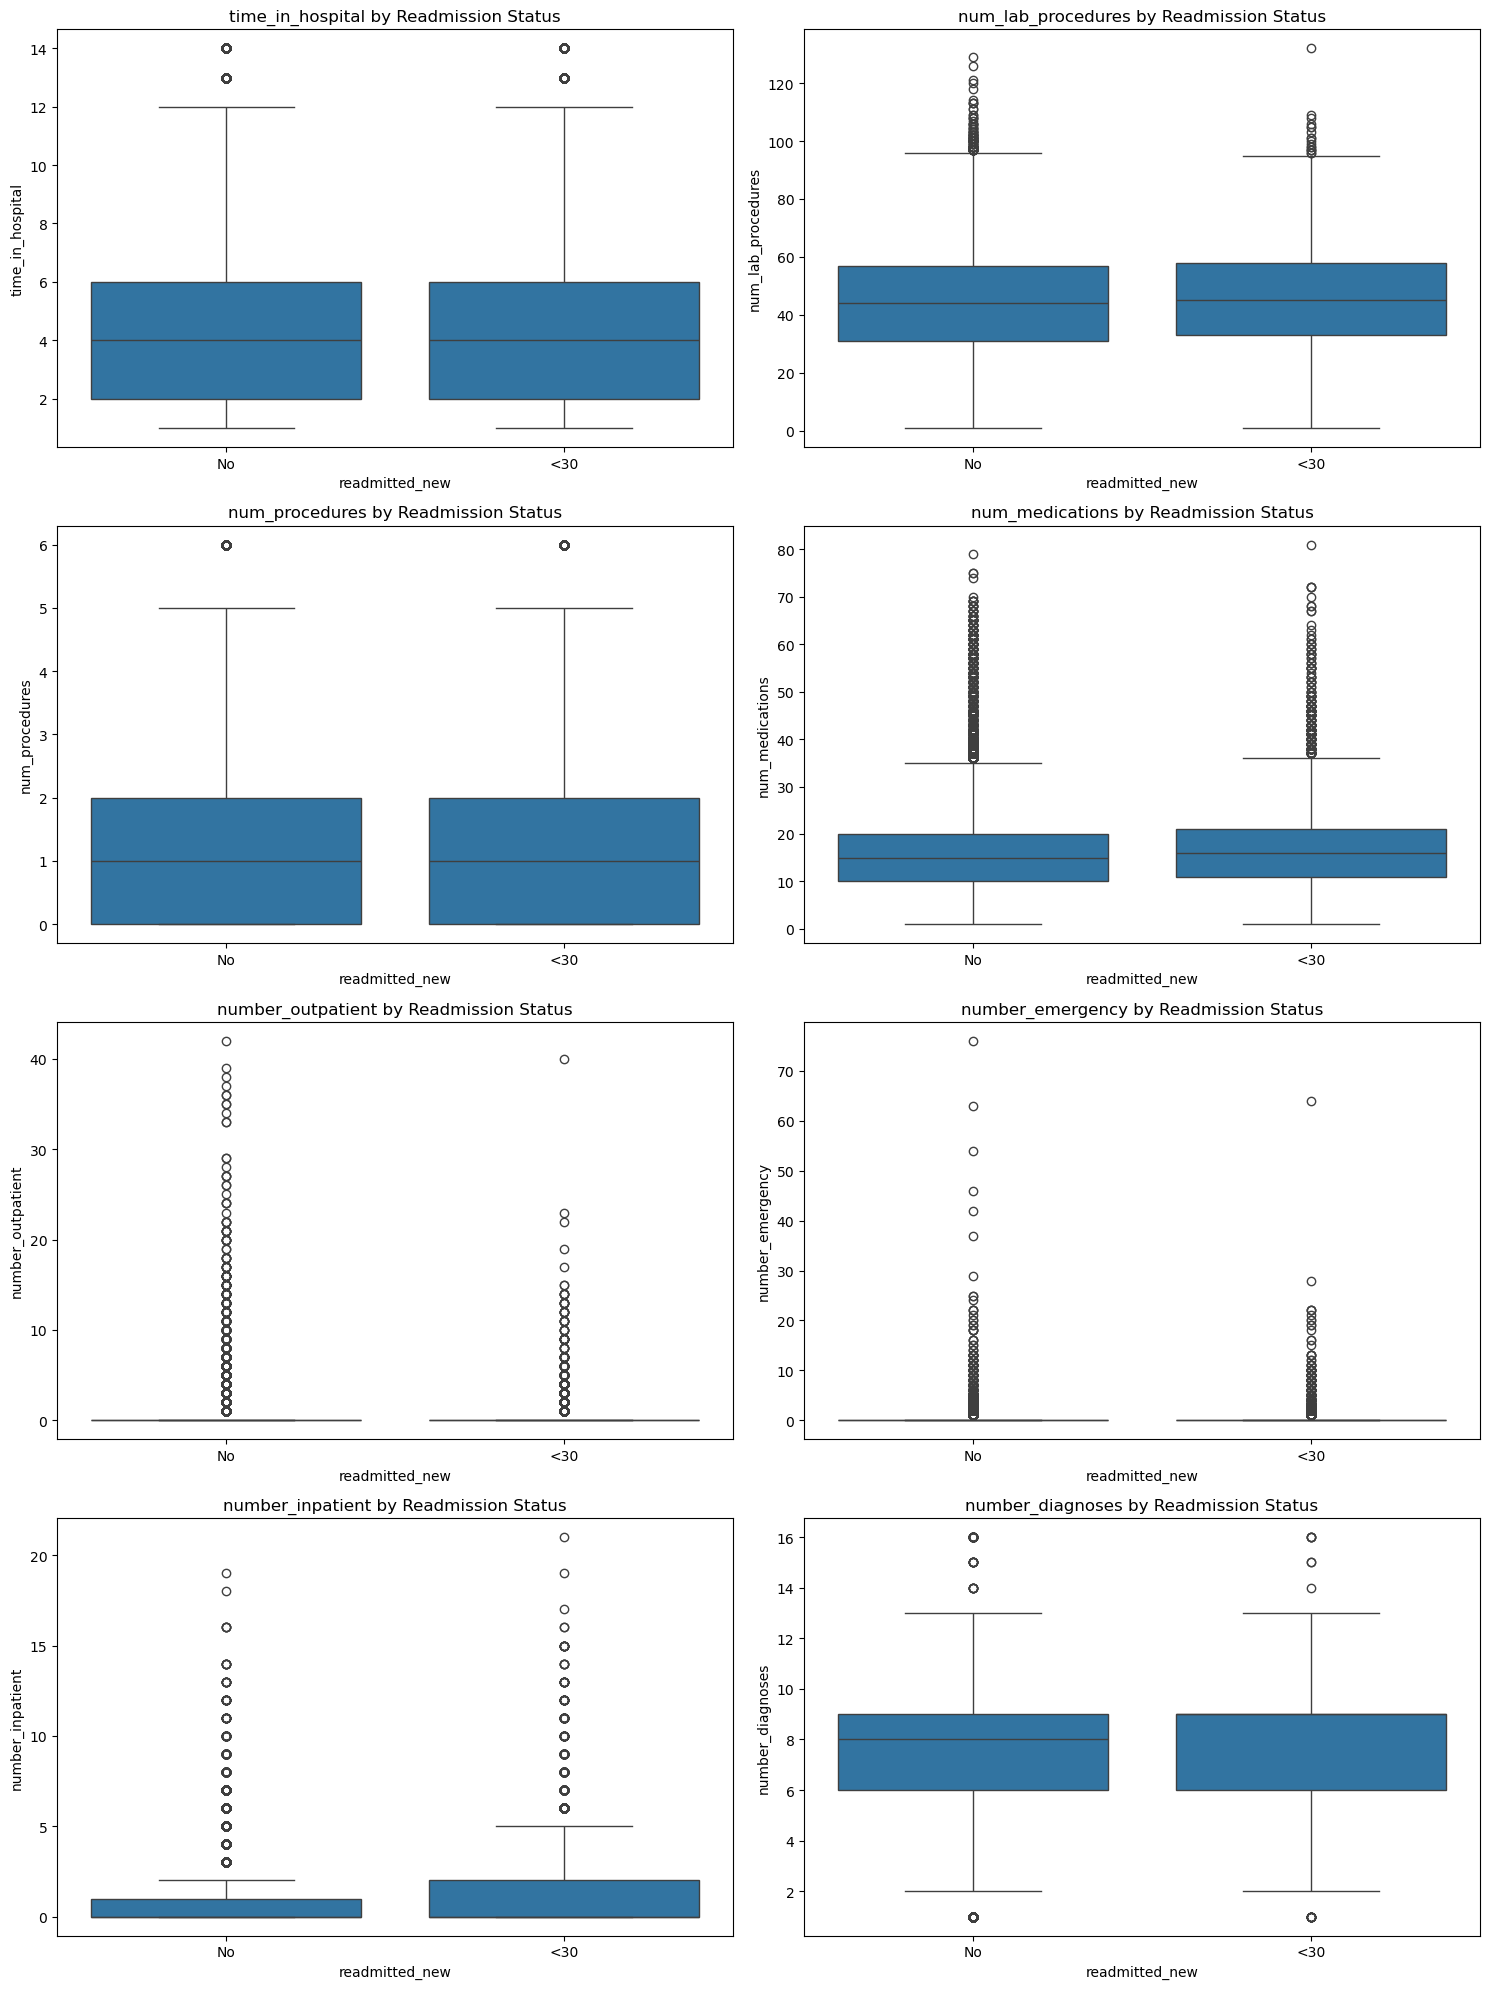

In [34]:
# Boxplots

# Set up the figure and axes
fig, axes = plt.subplots(nrows=math.ceil(len(columns_to_plot)/2), ncols=2, figsize=(15, 20))

# Flatten axes array for easier iteration
axes = axes.flatten()

# Create a violin plot for each column
for i, column in enumerate(columns_to_plot):
    sns.boxplot(x='readmitted_new', y=column, data=df_unique_patients, ax=axes[i])
    axes[i].set_title(f'{column} by Readmission Status')

# Adjust the layout
plt.tight_layout()
plt.show()

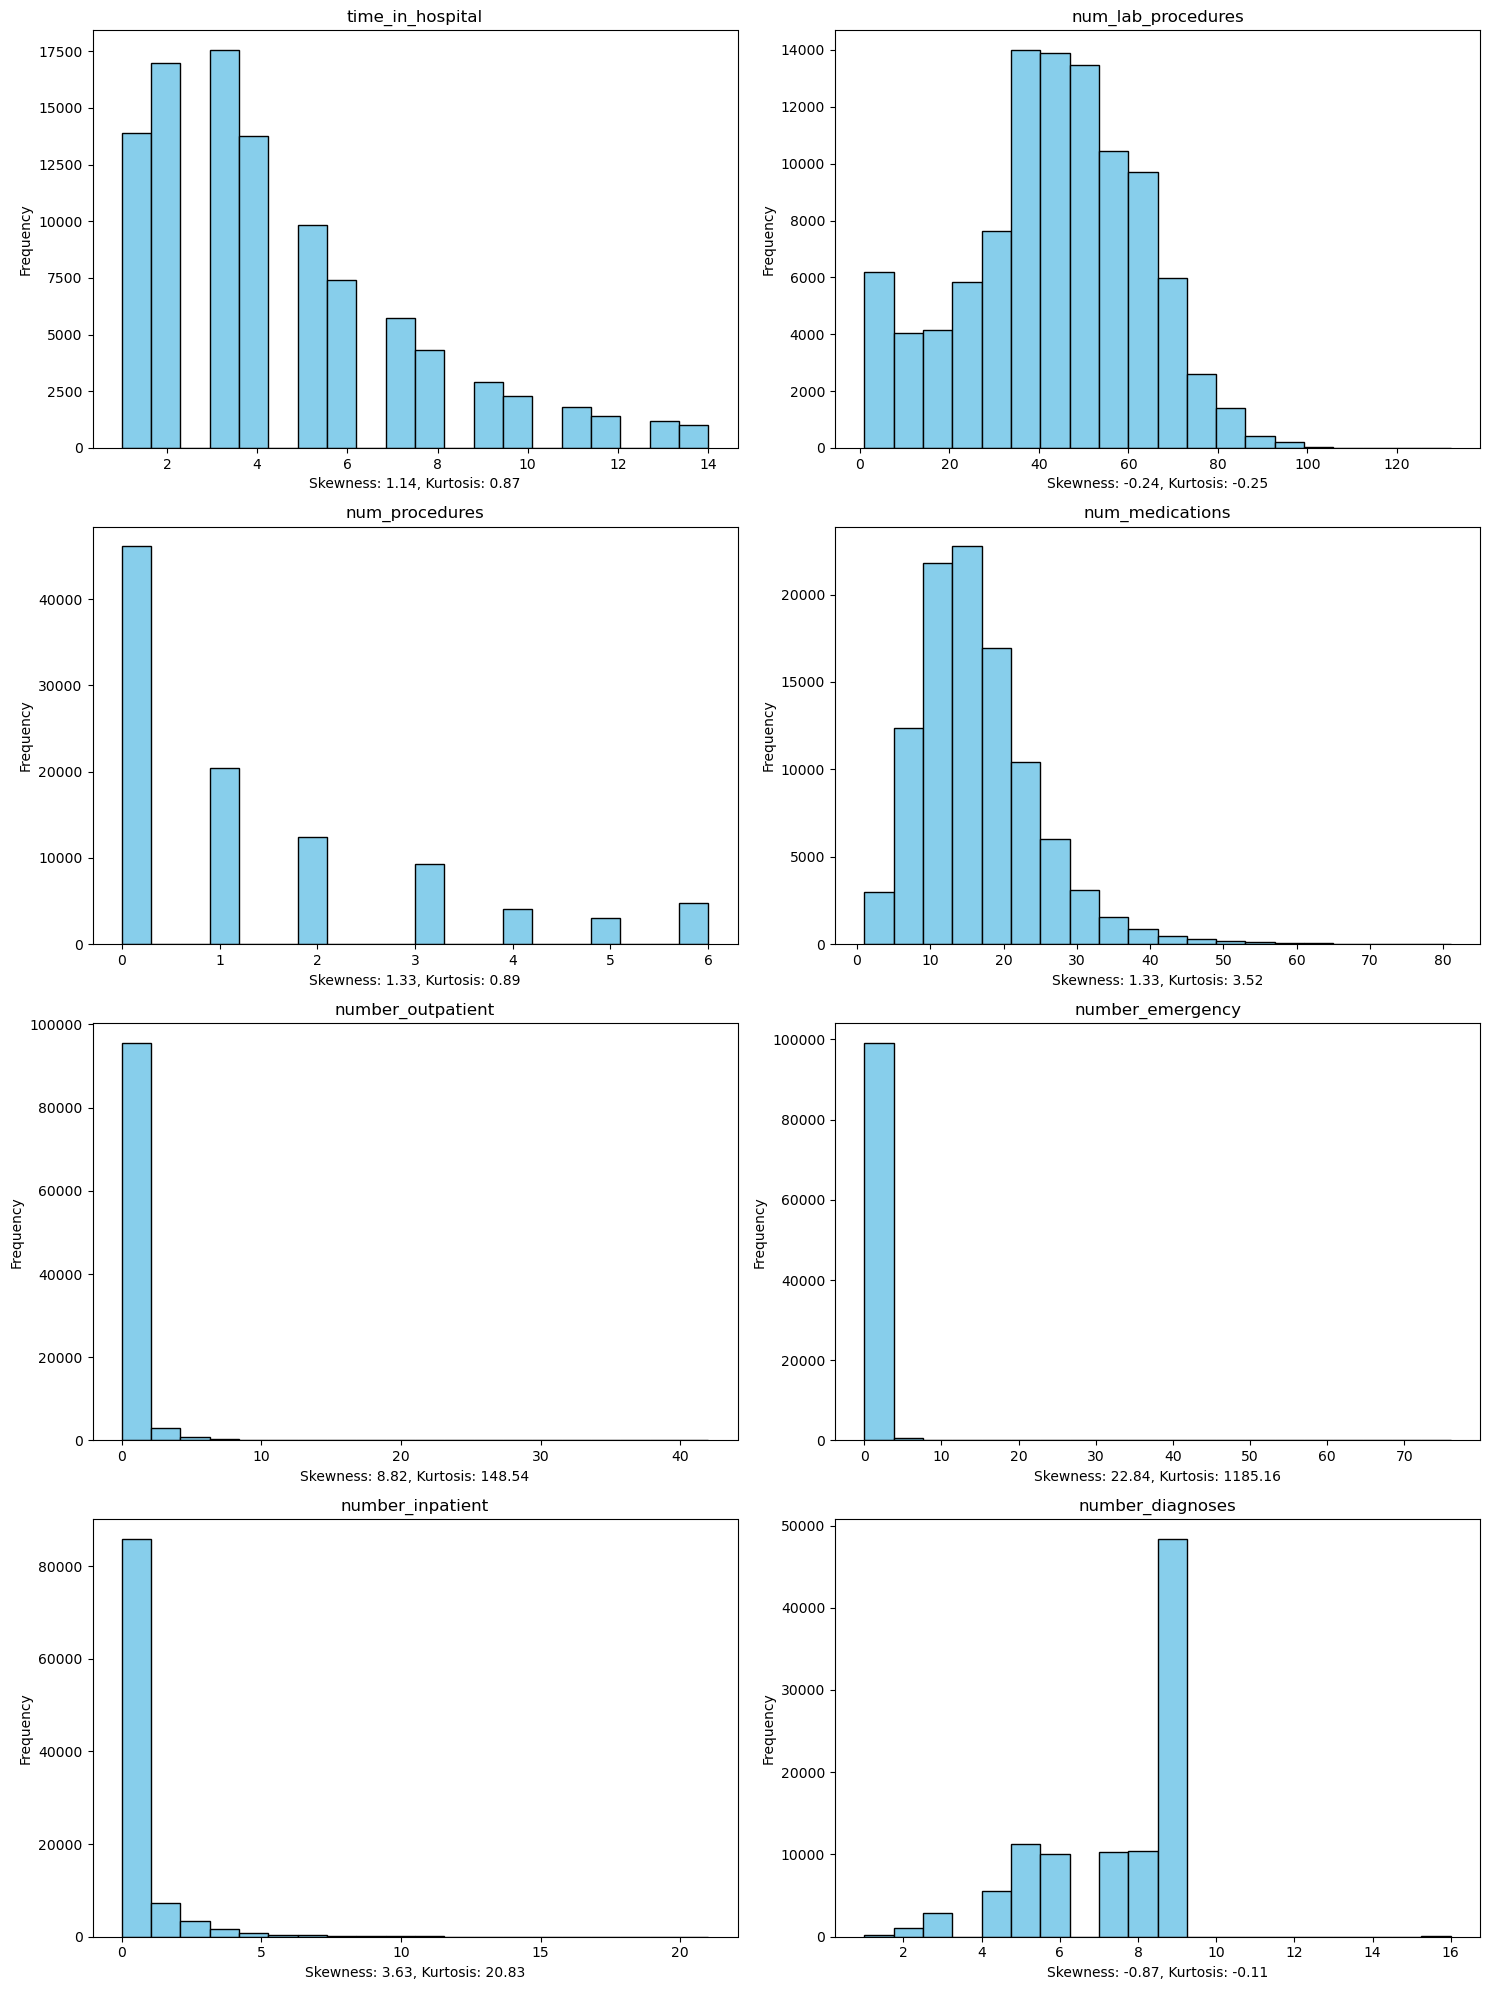

In [35]:
# Histograms

# Set up the figure and axes
fig, axes = plt.subplots(nrows=math.ceil(len(columns_to_plot)/2), ncols=2, figsize=(15, 20))

# Flatten axes array for easier iteration
axes = axes.flatten()

# Loop over columns and axes to plot histograms
for i, column in enumerate(columns_to_plot):
    # Plot histogram
    axes[i].hist(df_unique_patients[column], bins=20, color='skyblue', edgecolor='black')
    
    # Calculate skewness and kurtosis
    skewness = skew(df_unique_patients[column])
    kurt = kurtosis(df_unique_patients[column])
    
    # Set the title and display skewness and kurtosis
    axes[i].set_title(f'{column}')
    axes[i].set_xlabel(f'Skewness: {skewness:.2f}, Kurtosis: {kurt:.2f}')
    axes[i].set_ylabel('Frequency')

# Adjust layout
plt.tight_layout()
plt.show()

In [36]:
# Use the helper funtion to determine min and max of description ranges
ICD_codes[['min_ICD_code', 'max_ICD_code']] = ICD_codes.apply(split_code_range, axis=1)

In [37]:
# Use the helper funtion to assign the description to the diagnosis based on the code
df_unique_patients['diag_1_description'] = df_unique_patients.apply(get_description, axis=1, df1=ICD_codes, column = 'diag_1')
df_unique_patients['diag_2_description'] = df_unique_patients.apply(get_description, axis=1, df1=ICD_codes, column = 'diag_2')
df_unique_patients['diag_3_description'] = df_unique_patients.apply(get_description, axis=1, df1=ICD_codes, column = 'diag_3')

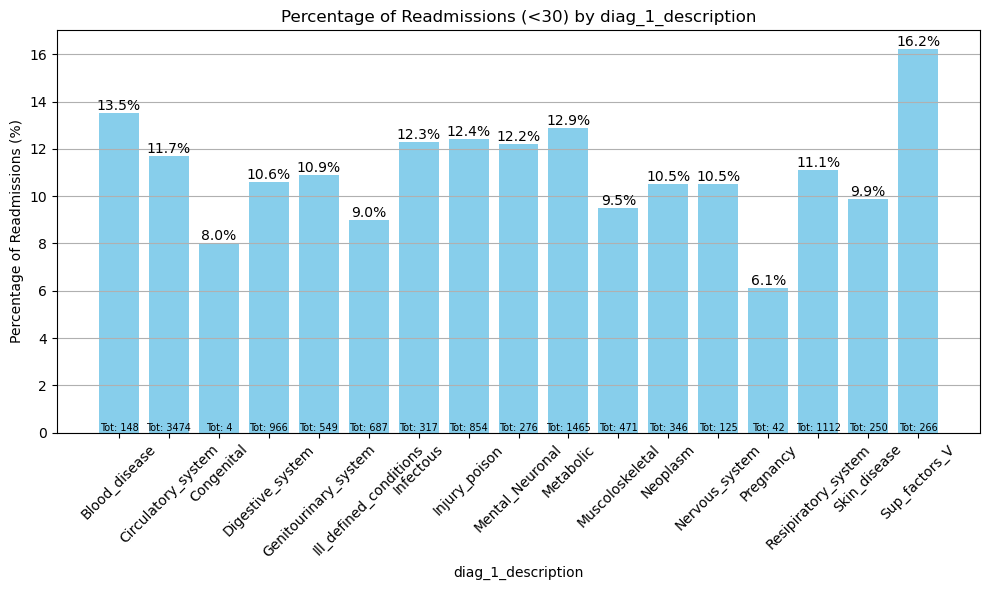

In [38]:
# Readmission by diagnosis 1
analyze_readmission(df_unique_patients, 'diag_1_description', 7)

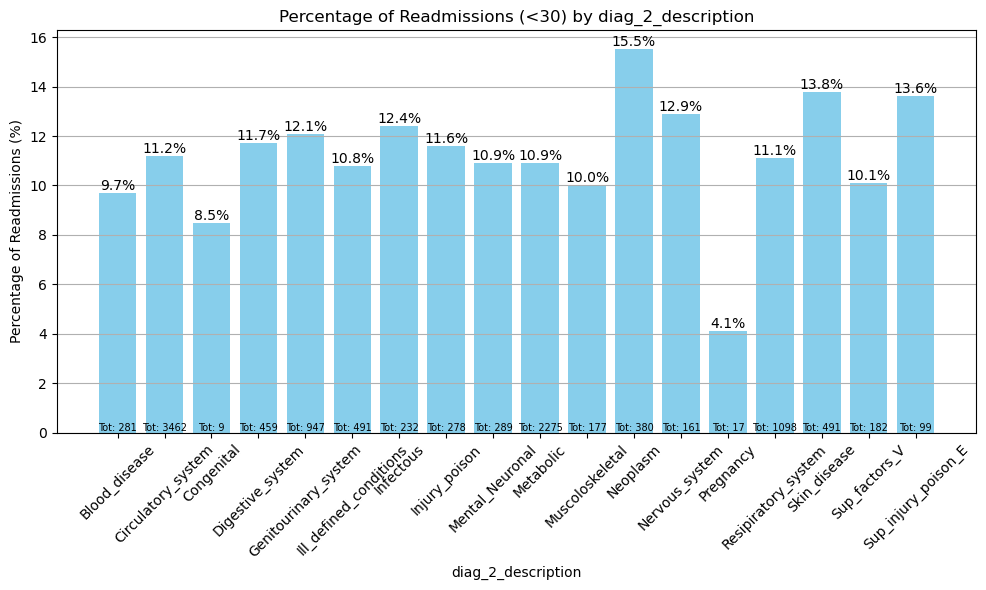

In [39]:
# Readmission by diagnosis 2
analyze_readmission(df_unique_patients, 'diag_2_description', 7)

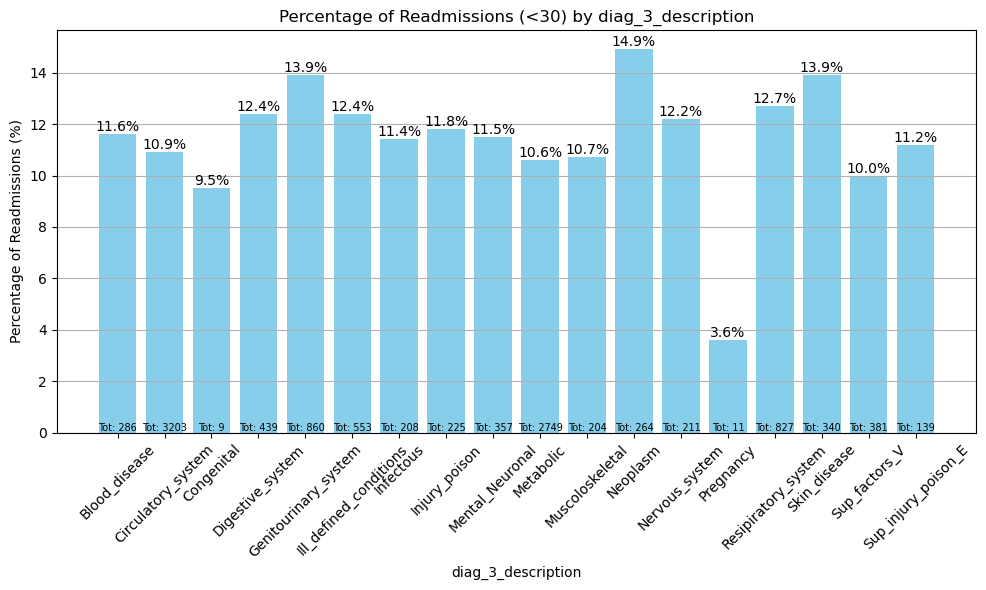

In [40]:
# Readmission by diagnosis 3
analyze_readmission(df_unique_patients, 'diag_3_description', 7)

In [41]:
# Melt the DataFrame to combine the diagnosis columns into one
df_melted = df_unique_patients.loc[:, ['encounter_id', 'diag_1_description', 'diag_2_description', 'diag_3_description']].melt(id_vars=['encounter_id'], var_name='diagnosis_type', value_name='diagnosis_value')

# One-hot encode the combined diagnosis column
df_one_hot = pd.get_dummies(df_melted['diagnosis_value'], prefix='', prefix_sep='')

# Group by 'patient_nbr' to combine the one-hot encoded columns back
df_final = df_one_hot.groupby(df_melted['encounter_id']).sum()

# Reset the index to add patient_nbr back to the DataFrame
df_final = df_final.reset_index()

df_unique_patients = df_unique_patients.merge(df_final, on='encounter_id', how='left', validate='m:1')

In [42]:
# Merge Max glu serum >200 and >300 in one (as >200 indicates diabetes)
df_unique_patients.loc[df_unique_patients.max_glu_serum.isin(['>300']), 'max_glu_serum'] = '>200'

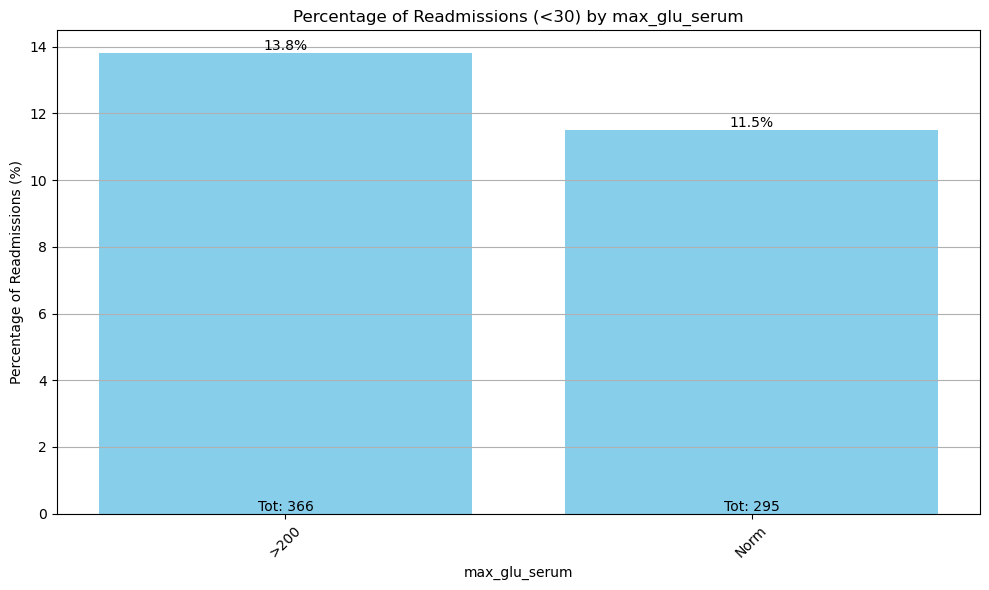

In [43]:
# Readmission by max_glu_serum
analyze_readmission(df_unique_patients, 'max_glu_serum')

In [44]:
# Merge A1Cresult >7 and >8 in one (as >6.5 indicates diabetes)
df_unique_patients.loc[df_unique_patients.A1Cresult.isin(['>8']), 'A1Cresult'] = '>7'

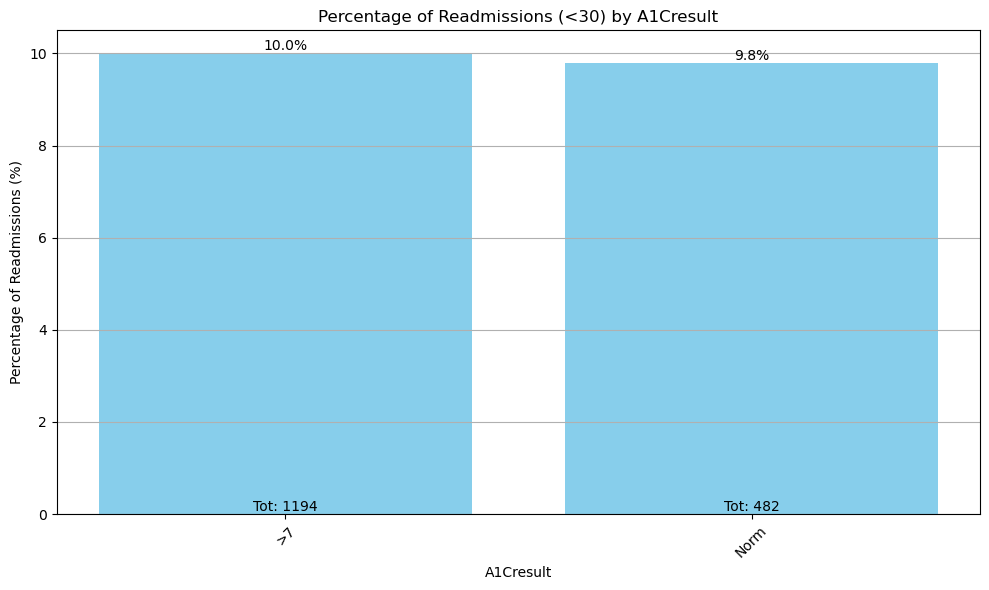

In [45]:
# Readmission by A1Cresult
analyze_readmission(df_unique_patients, 'A1Cresult')

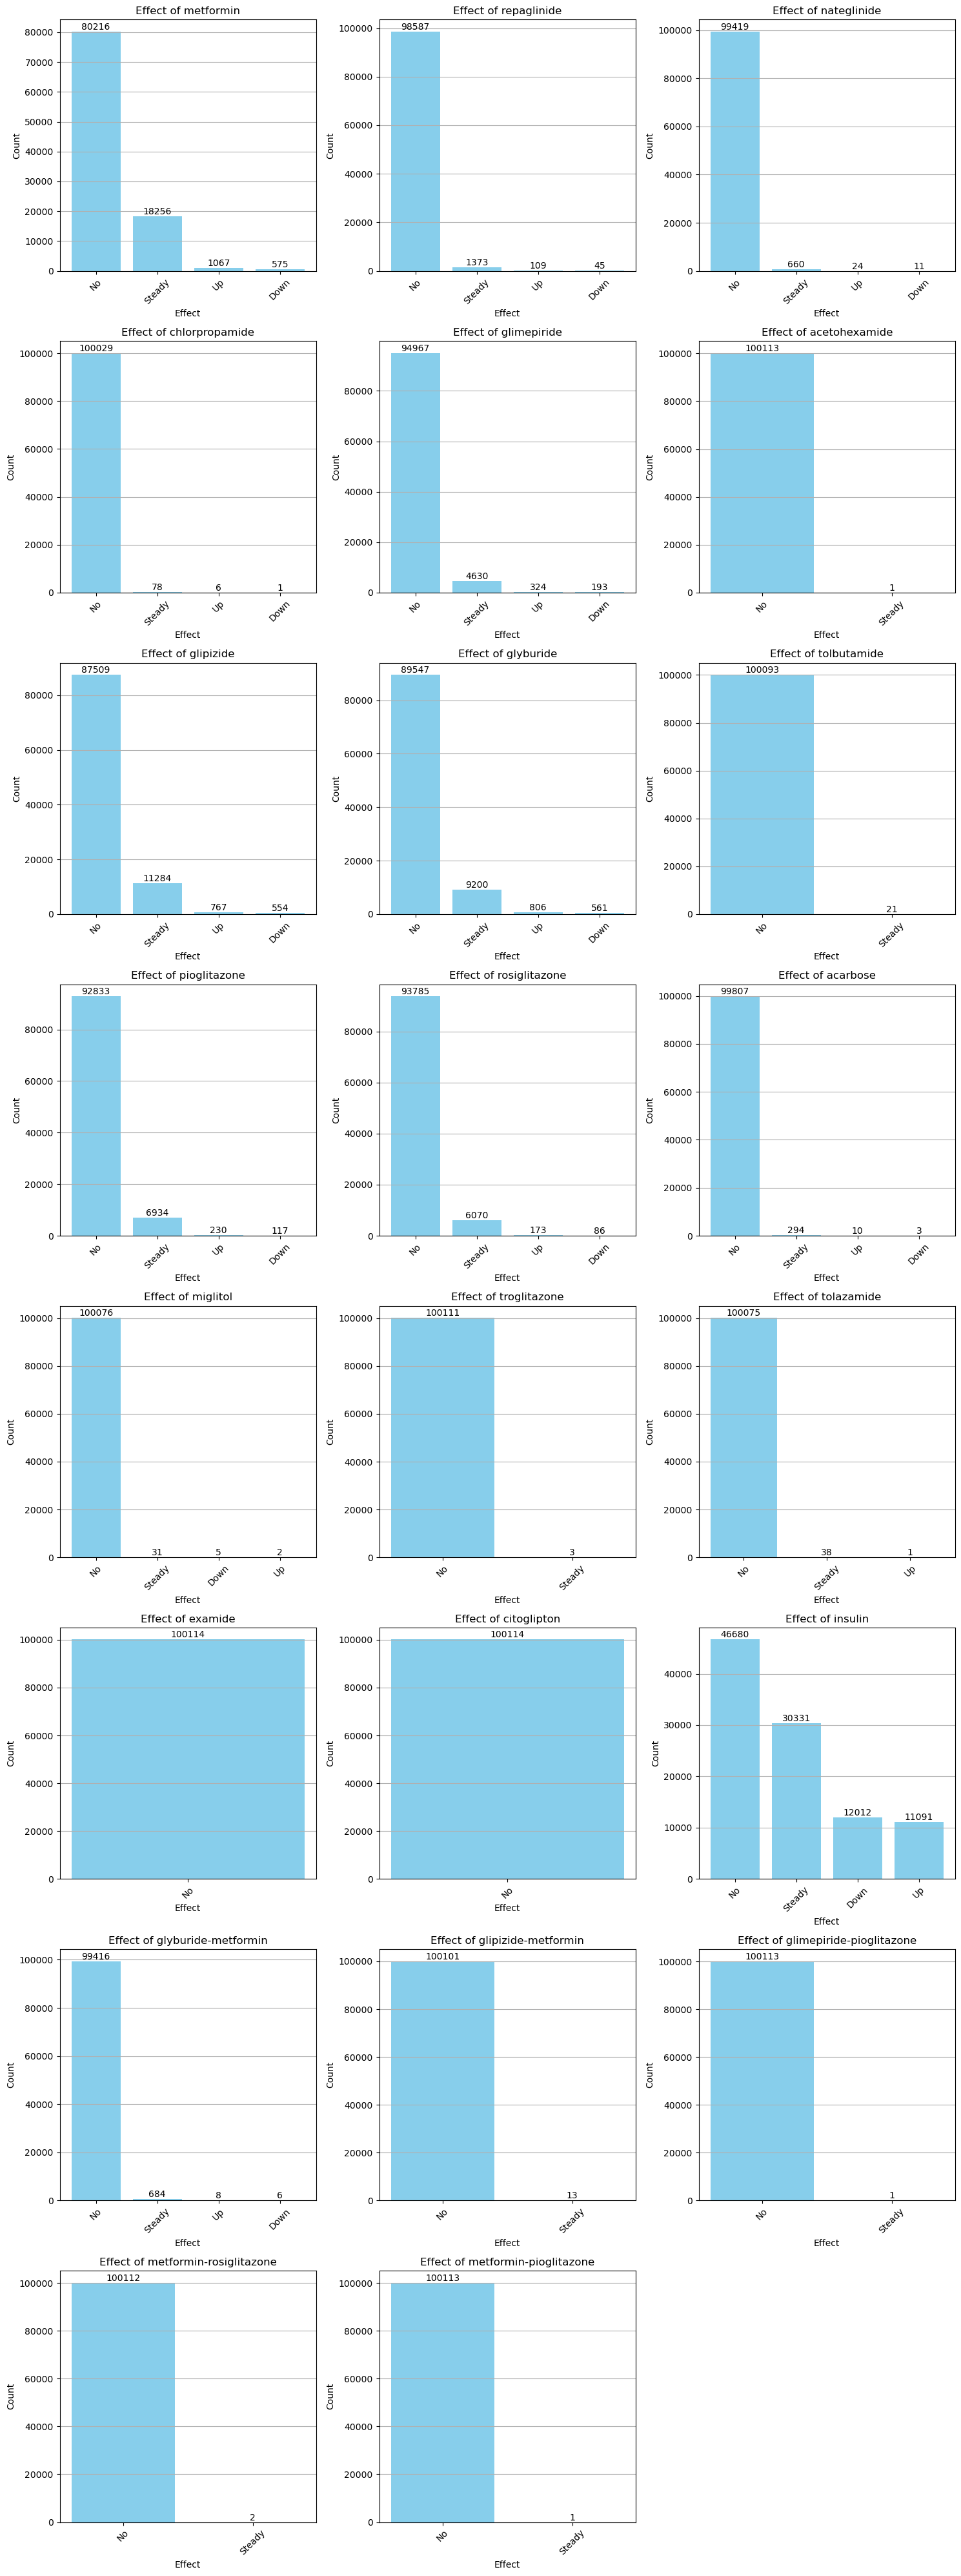

In [46]:
#Plot graphs for medications 

drug_columns = [
    'metformin', 'repaglinide', 'nateglinide', 'chlorpropamide', 
    'glimepiride', 'acetohexamide', 'glipizide', 'glyburide', 
    'tolbutamide', 'pioglitazone', 'rosiglitazone', 'acarbose', 
    'miglitol', 'troglitazone', 'tolazamide', 'examide', 
    'citoglipton', 'insulin', 'glyburide-metformin', 
    'glipizide-metformin', 'glimepiride-pioglitazone', 
    'metformin-rosiglitazone', 'metformin-pioglitazone'
]

# Set the number of plots and configure the layout
num_drugs = len(drug_columns)
cols = 3  # Number of columns in the subplot grid
rows = (num_drugs // cols) + (num_drugs % cols > 0)  # Calculate the number of rows needed

plt.figure(figsize=(15, 5 * rows))  # Adjust figure size based on number of rows

for i, column in enumerate(drug_columns):
    # Count occurrences of each category in the column
    counts = df_unique_patients[column].value_counts()
    
    # Create a subplot for each drug effect
    plt.subplot(rows, cols, i + 1)
    bars = plt.bar(counts.index, counts.values, color='skyblue')
    plt.title(f'Effect of {column}')
    plt.xlabel('Effect')
    plt.ylabel('Count')
    plt.xticks(rotation=45)
    plt.grid(axis='y')

    # Add data labels above each bar
    for bar in bars:
        yval = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2, yval, yval, ha='center', va='bottom')

# Show the plots
plt.tight_layout()
plt.show()

In [47]:
# The following columns were dropped as the are mostly NO
med_cols_to_drop = ['acetohexamide', 'troglitazone', 'examide', 'citoglipton', 'glipizide-metformin', 'glimepiride-pioglitazone', 
                    'metformin-rosiglitazone', 'metformin-pioglitazone']

df_unique_patients.drop(columns=med_cols_to_drop, inplace=True)

In [48]:
#Create new features based on medication changes.

med_cols_features = ['metformin', 'repaglinide', 'nateglinide', 'chlorpropamide', 'glimepiride',  'glipizide', 'glyburide', 
     'pioglitazone', 'rosiglitazone', 'acarbose', 'miglitol',  'tolazamide', 'insulin', 'glyburide-metformin'] 

# Count for num_med_prescribed: Count occurrences of "up", "down", "steady"
df_unique_patients['num_med_prescribed'] = df_unique_patients[med_cols_features].isin(['Up', 'Down', 'Steady']).sum(axis=1)

# Count for num_med_changes: Count occurrences of "up", "down"
df_unique_patients['num_med_changes'] = df_unique_patients[med_cols_features].isin(['Up', 'Down']).sum(axis=1)

# Count for num_med_increases: Count occurrences of "up"
df_unique_patients['num_med_increases'] = df_unique_patients[med_cols_features].isin(['Up']).sum(axis=1)

# Count for num_med_decreases: Count occurrences of "down"
df_unique_patients['num_med_decreases'] = df_unique_patients[med_cols_features].isin(['Down']).sum(axis=1)

In [49]:
# Create time series values for num_prev_visits, avg_time_in_hospital and max_time_in_hospital
# This won´t be used as all records approach was selected. 
# aggregated_df = df.groupby('patient_nbr').agg(
#                 num_visits=('encounter_id', 'count'),          
#                 avg_time_hospital=('time_in_hospital', 'mean'),      
#                 max_time_hospital=('time_in_hospital', 'max'),                    
#                 ).reset_index()

# # Discount the patients last visit
# aggregated_df['num_visits'] = aggregated_df['num_visits'] - 1

# #Filter only patients that have had previous visits
# aggregated_df = aggregated_df.loc[aggregated_df['num_visits'] >= 1, :]

# #Join the dataframe with the new time series columns
# df_unique_patients = df_unique_patients.merge(aggregated_df, on='patient_nbr', how='left', validate='m:1')

# #Fill NAs
# df_unique_patients[['num_visits', 'avg_time_hospital', 'max_time_hospital']] = df_unique_patients[['num_visits', 'avg_time_hospital', 'max_time_hospital']].fillna(0)

In [50]:
#Create a copy of the dataframe to encode and drop columns
df_unique_patients_encoded = df_unique_patients.copy(deep=True)

# One-Hot Encode categorical columns
columns_to_encode=['race_cleaned', 'gender', 'age', 'admission_description', 'discharge_description', 'admission_source_description', 
                   'max_glu_serum', 'A1Cresult','change', 'diabetesMed']

df_unique_patients_encoded = pd.get_dummies(df_unique_patients_encoded, columns=columns_to_encode)

# Drop columns not needed for the model
columns_to_drop=['race',  'admission_type_id', 'discharge_disposition_id', 'admission_source_id',
                  'diag_1', 'diag_2', 'diag_3', 'metformin', 'repaglinide', 'nateglinide', 'chlorpropamide', 'glimepiride', 'glipizide', 
                  'glyburide', 'tolbutamide', 'pioglitazone', 'rosiglitazone', 'acarbose', 'miglitol', 'tolazamide', 'insulin', 
                  'glyburide-metformin', 'readmitted', 'diag_1_description', 'diag_2_description', 'diag_3_description', 'race_cleaned_Other',
                  'race_cleaned_Unknown', 'gender_Female', 'gender_Unknown/Invalid', 'admission_description_No Data', 'discharge_description_Not_Mapped',
                  'admission_source_description_Not_Mapped','admission_source_description_Other', 'change_No','diabetesMed_No']

df_unique_patients_encoded = df_unique_patients_encoded.drop(columns=columns_to_drop, axis = 1)

In [51]:
# Convert the target feature in binary
df_unique_patients_encoded['readmitted_new'] = df_unique_patients_encoded['readmitted_new'].apply(lambda x: True if x == '<30' else False)

In [52]:
display(Markdown("""
# Feature selection

- Spearman correlation matrix was calculated as variables do not satify the linear relationship requirement for pearson. There are a couple of 
variables that have a correlation close to one. However, tree based methods can perform correctly even with some correlation. Features were left.

- No need to do dimensionality reduction (i.e. PCA).
"""))


# Feature selection

- Spearman correlation matrix was calculated as variables do not satify the linear relationship requirement for pearson. There are a couple of 
variables that have a correlation close to one. However, tree based methods can perform correctly even with some correlation. Features were left.

- No need to do dimensionality reduction (i.e. PCA).


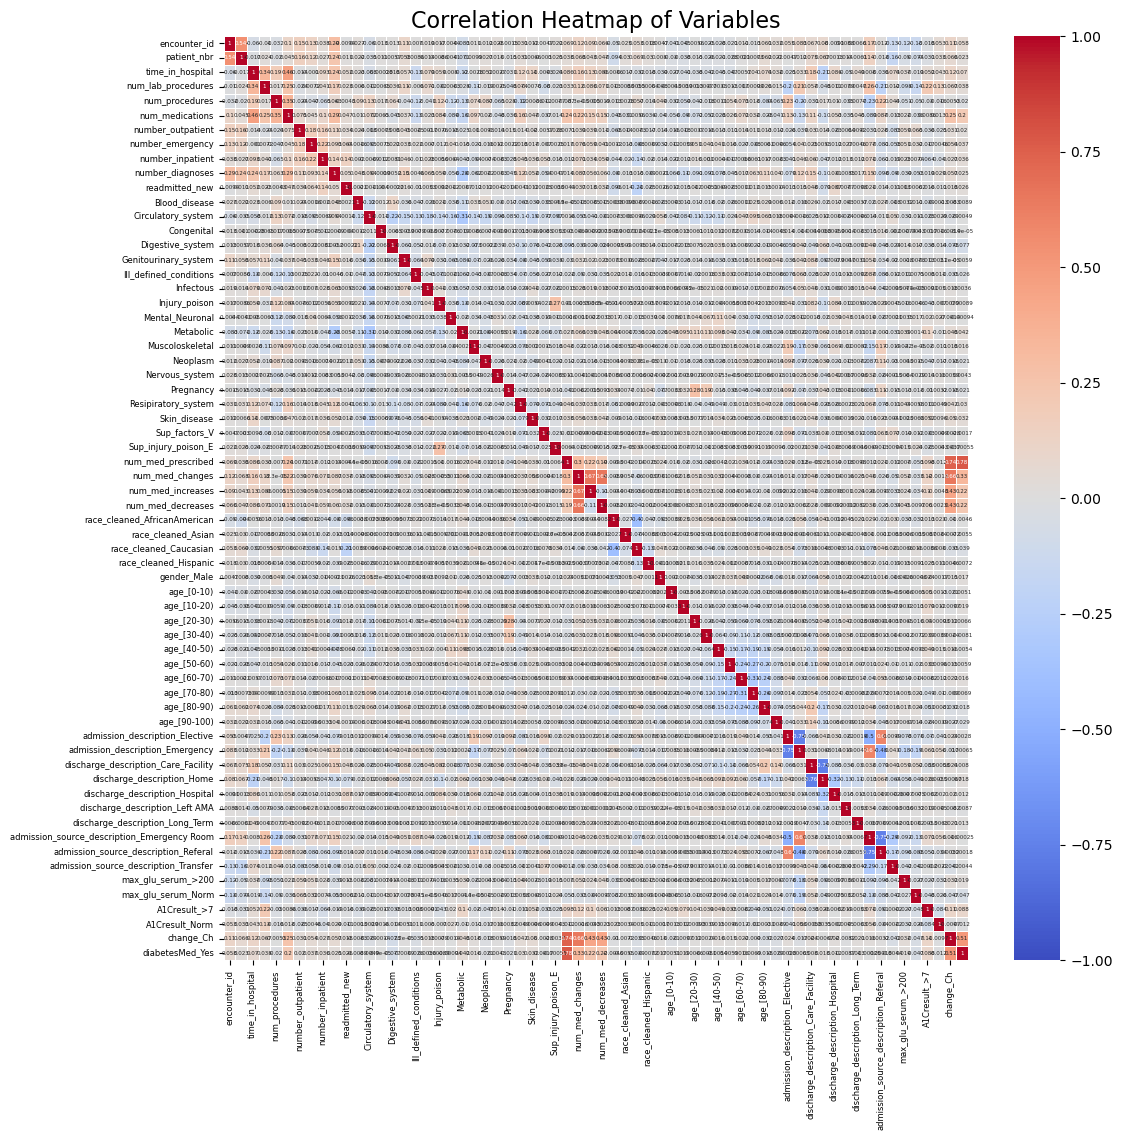

In [53]:
correlation_df = df_unique_patients_encoded.corr(method='spearman')

# Set up the matplotlib figure
plt.figure(figsize=(12, 12))

# Draw the heatmap
sns.heatmap(correlation_df, annot=True, cmap='coolwarm', center=0, vmin=-1, vmax=1, linewidths=.5, annot_kws={"size": 4})

plt.xticks(fontsize=6)
plt.yticks(fontsize=6)

# Set the title
plt.title('Correlation Heatmap of Variables', fontsize=16)

# Show the plot
plt.show()

In [102]:
display(Markdown("""
# Train and test set

##### A train set (80%) and test set (20%) was made. Stratified spliting was performed taking into account both the target variable (readmissions) and the patients (patients were either in test or train irrespective of the number of visits) 
"""))


# Train and test set

##### A train set (80%) and test set (20%) was made. Stratified spliting was performed taking into account both the target variable (readmissions) and the patients (patients were either in test or train irrespective of the number of visits) 


In [55]:
# Aggregate the dataset by patient_nbr, ensuring each patient appears only once
df_grouped = df_unique_patients_encoded.groupby('patient_nbr').agg({'readmitted_new': 'max'}).reset_index()

# Prepare the stratified split on the aggregated dataset
stratified_split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)

# Perform the stratified split on the grouped data
for train_group_idx, test_group_idx in stratified_split.split(df_grouped, df_grouped['readmitted_new']):
    train_groups = df_grouped.iloc[train_group_idx]['patient_nbr']
    test_groups = df_grouped.iloc[test_group_idx]['patient_nbr']

# Split the original dataset based on the patient groups
train_df = df_unique_patients_encoded[df_unique_patients_encoded['patient_nbr'].isin(train_groups)]
test_df = df_unique_patients_encoded[df_unique_patients_encoded['patient_nbr'].isin(test_groups)]

# Separate features and target for train/test
X_train = train_df.drop(columns=['readmitted_new'])
y_train = train_df['readmitted_new']
X_test = test_df.drop(columns=['readmitted_new', 'encounter_id', 'patient_nbr'])
y_test = test_df['readmitted_new']

In [56]:
display(Markdown("""
# Data Augmentation

##### Various data augmentation techniques were used:

- **Oversampling**: Generate either random duplicate records or syntetic records (SMOTE) of True values.
- **Undersampling**: Reduce the number of False records to match the true ones.

##### The model yielded better results with undersampling so that approach was taken.  

"""))


# Data Augmentation

##### Various data augmentation techniques were used:

- **Oversampling**: Generate either random duplicate records or syntetic records (SMOTE) of True values.
- **Undersampling**: Reduce the number of False records to match the true ones.

##### The model yielded better results with undersampling so that approach was taken.  



In [57]:
#Instantiate the random oversampler
#ros = RandomOverSampler(random_state=42)

#Instantiate the SMOTE object
#smote = SMOTE(random_state=42)

#Instantiate the random undersampler
rus = RandomUnderSampler(random_state=42)

# Resample the dataset
X_resampled, y_resampled = rus.fit_resample(X_train, y_train)

# Check the distribution after resampling
print("Before resampling:")
print(y_train.value_counts())
print("\nAfter resampling:")
print(pd.Series(y_resampled).value_counts())

Before resampling:
readmitted_new
False    71043
True      9106
Name: count, dtype: int64

After resampling:
readmitted_new
False    9106
True     9106
Name: count, dtype: int64


In [58]:
#Create groups for stratfified sampling
groups = X_resampled.patient_nbr

#Drop 'encounter_id' and 'patient_nbr' as these are not features
X_resampled = X_resampled.drop(['encounter_id', 'patient_nbr'], axis=1)

In [59]:
display(Markdown("""
# Modeling

##### Three models were used. Tree based models were picked as they are robust to untransformed features/label and can account for non linear relationships. 

- **Random Forest**
- **XGB Classifier**
- **Cat Boost Classifier**

##### A 5-fold cross validation was performed together with hyperparameter tuning. This helps prevent overfitting while the model calculates the best parameters. The validation splits were also performed taking into account the label and unique patients principles. 

##### Tried different scoring options such as accuracy, balanced accuracy, precision and recall. Since this is a medical environment, it would be better to reduce the type II error (false negatives) as it is more costly to wrongly discharge a patient that could come back in 30 days or less. There was no signicant improvement seen by varying the scoring.

##### Accuracy, precision, recall and F1 scores were calculated for the best of each of models tested.

##### Confusion matrix and feature importance graphs were also plotted.

##### Most important features were race, number of hospital visits, number of procedures and number of medications. This makes sense as race could point to a genetic component (race), while the other features may point to patient health status (i.e. the more sick a person is, the more visits to the hospital and a higher chance of coming back before 30 days).

"""))


# Modeling

##### Three models were used. Tree based models were picked as they are robust to untransformed features/label and can account for non linear relationships. 

- **Random Forest**
- **XGB Classifier**
- **Cat Boost Classifier**

##### A 5-fold cross validation was performed together with hyperparameter tuning. This helps prevent overfitting while the model calculates the best parameters. The validation splits were also performed taking into account the label and unique patients principles. 

##### Tried different scoring options such as accuracy, balanced accuracy, precision and recall. Since this is a medical environment, it would be better to reduce the type II error (false negatives) as it is more costly to wrongly discharge a patient that could come back in 30 days or less. There was no signicant improvement seen by varying the scoring.

##### Accuracy, precision, recall and F1 scores were calculated for the best of each of models tested.

##### Confusion matrix and feature importance graphs were also plotted.

##### Most important features were race, number of hospital visits, number of procedures and number of medications. This makes sense as race could point to a genetic component (race), while the other features may point to patient health status (i.e. the more sick a person is, the more visits to the hospital and a higher chance of coming back before 30 days).



In [60]:
# Define the Random Forest model
rf_model = RandomForestClassifier(random_state=42, n_jobs=-1, class_weight='balanced')

# Define the search space for hyperparameters
param_space = {
    'n_estimators': (50, 300),          
    'max_depth': (1, 30),               
    'min_samples_split': (2, 20),       
    'min_samples_leaf': (1, 10)         
}

# Initialize StratifiedGroupKFold for cross-validation
cv = StratifiedGroupKFold(n_splits=5)

# Initialize BayesSearchCV
bayes_search = BayesSearchCV(
    estimator=rf_model, 
    search_spaces=param_space,
    n_iter=50,
    cv=cv, 
    scoring='balanced_accuracy', 
    random_state=42,
    n_jobs=-1
)

# Fit the Bayesian optimizer on the dataset (with grouped patients)
bayes_search.fit(X_resampled, y_resampled, groups=groups)

# Best hyperparameters from Bayesian optimization
print("Best parameters:", bayes_search.best_params_)

# Train the final model with the best hyperparameters on the entire dataset
best_model_rf = bayes_search.best_estimator_
best_model_rf.fit(X_resampled, y_resampled)

# Make predictions on the test set
y_pred = best_model_rf.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")

# Generate the classification report
report_rf = classification_report(y_test, y_pred, output_dict=True)

# Generate the confusion matrix
conf_matrix_rf = confusion_matrix(y_test, y_pred)

# Get feature importance
feature_importance_rf = best_model_rf.feature_importances_

# Random Forest
rf_probs = best_model_rf.predict_proba(X_test)[:, 1]

# Random Forest ROC
rf_fpr, rf_tpr, rf_thresholds = roc_curve(y_test, rf_probs)
rf_auc = roc_auc_score(y_test, rf_probs)

Best parameters: OrderedDict({'max_depth': 13, 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 50})
Accuracy: 0.70


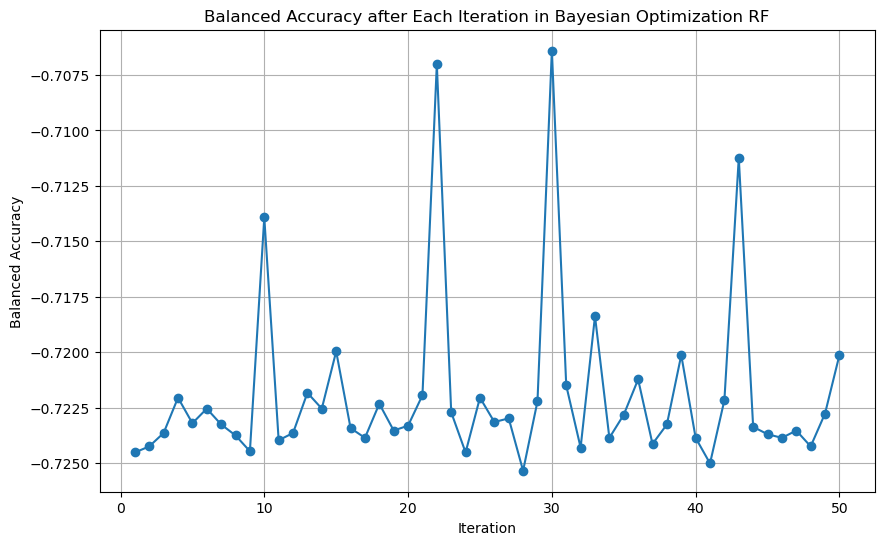

Best parameters: OrderedDict({'max_depth': 13, 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 50})


In [62]:
errors_rf = -bayes_search.cv_results_['mean_test_score']

# Plot the error after each iteration
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(errors_rf) + 1), errors_rf, marker='o')
plt.title('Balanced Accuracy after Each Iteration in Bayesian Optimization RF')
plt.xlabel('Iteration')
plt.ylabel('Balanced Accuracy')
plt.grid(True)
plt.show()

# Best hyperparameters from Bayesian optimization
print("Best parameters:", bayes_search.best_params_)

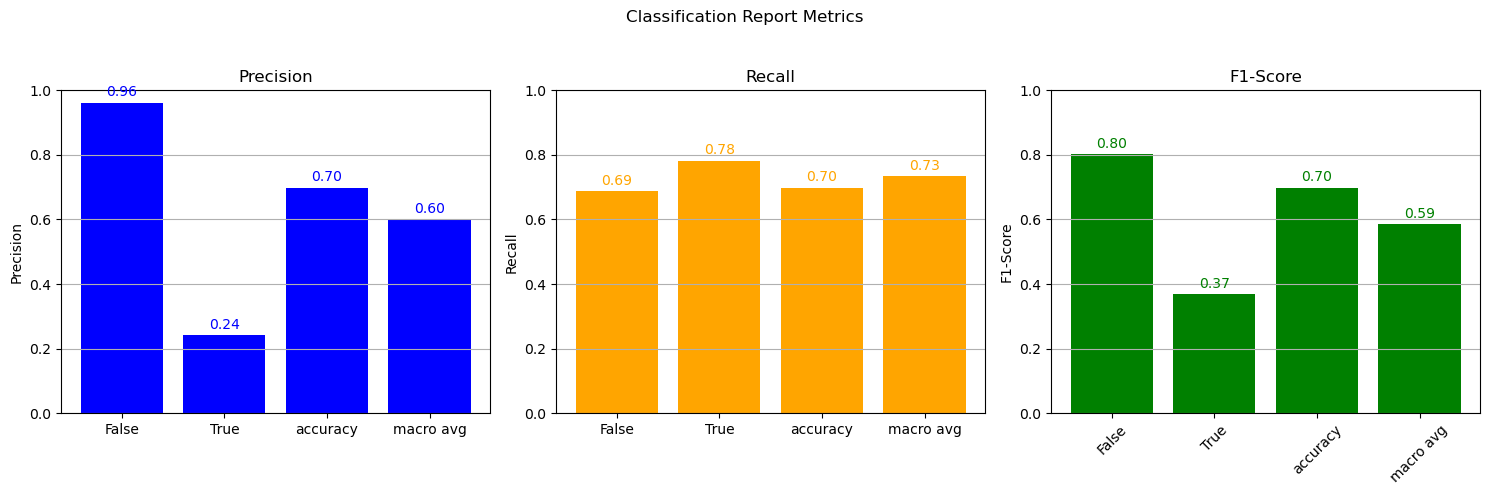

In [64]:
# Convert to DataFrame
report_df = pd.DataFrame(report_rf).transpose()

# Dropping 'support' for clearer plots
report_df = report_df.drop(columns=['support'])

# Set class names for better readability
class_names = report_df.index[:-1]  # Exclude 'accuracy' row

# Plotting
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15, 5))

# Bar plot for Precision
axes[0].bar(class_names, report_df['precision'][:-1], color='blue')
axes[0].set_title('Precision')
axes[0].set_ylim(0, 1)
axes[0].set_ylabel('Precision')
axes[0].grid(axis='y')

# Adding value labels
for i, v in enumerate(report_df['precision'][:-1]):
    axes[0].text(i, v + 0.02, f"{v:.2f}", ha='center', color='blue')

# Bar plot for Recall
axes[1].bar(class_names, report_df['recall'][:-1], color='orange')
axes[1].set_title('Recall')
axes[1].set_ylim(0, 1)
axes[1].set_ylabel('Recall')
axes[1].grid(axis='y')

# Adding value labels
for i, v in enumerate(report_df['recall'][:-1]):
    axes[1].text(i, v + 0.02, f"{v:.2f}", ha='center', color='orange')

# Bar plot for F1-score
axes[2].bar(class_names, report_df['f1-score'][:-1], color='green')
axes[2].set_title('F1-Score')
axes[2].set_ylim(0, 1)
axes[2].set_ylabel('F1-Score')
axes[2].grid(axis='y')

# Adding value labels
for i, v in enumerate(report_df['f1-score'][:-1]):
    axes[2].text(i, v + 0.02, f"{v:.2f}", ha='center', color='green')

plt.suptitle('Classification Report Metrics')
plt.xticks(rotation=45)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

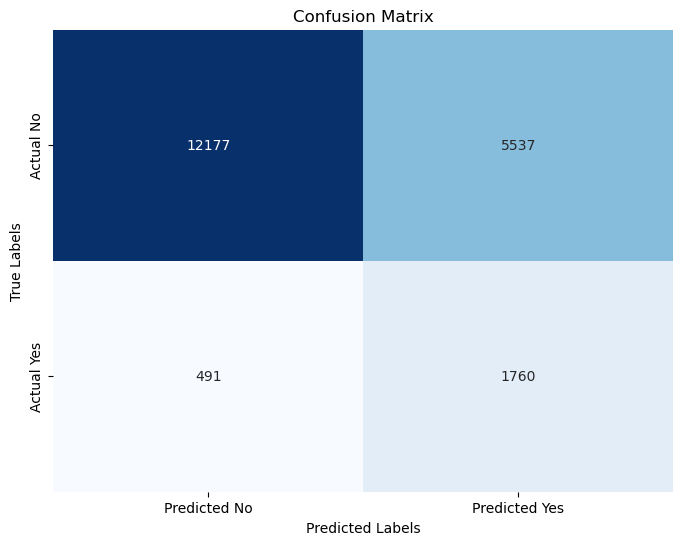

In [65]:
# Create a heatmap using seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_rf, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Predicted No', 'Predicted Yes'],
            yticklabels=['Actual No', 'Actual Yes'])

# Add labels, title, and axes ticks
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

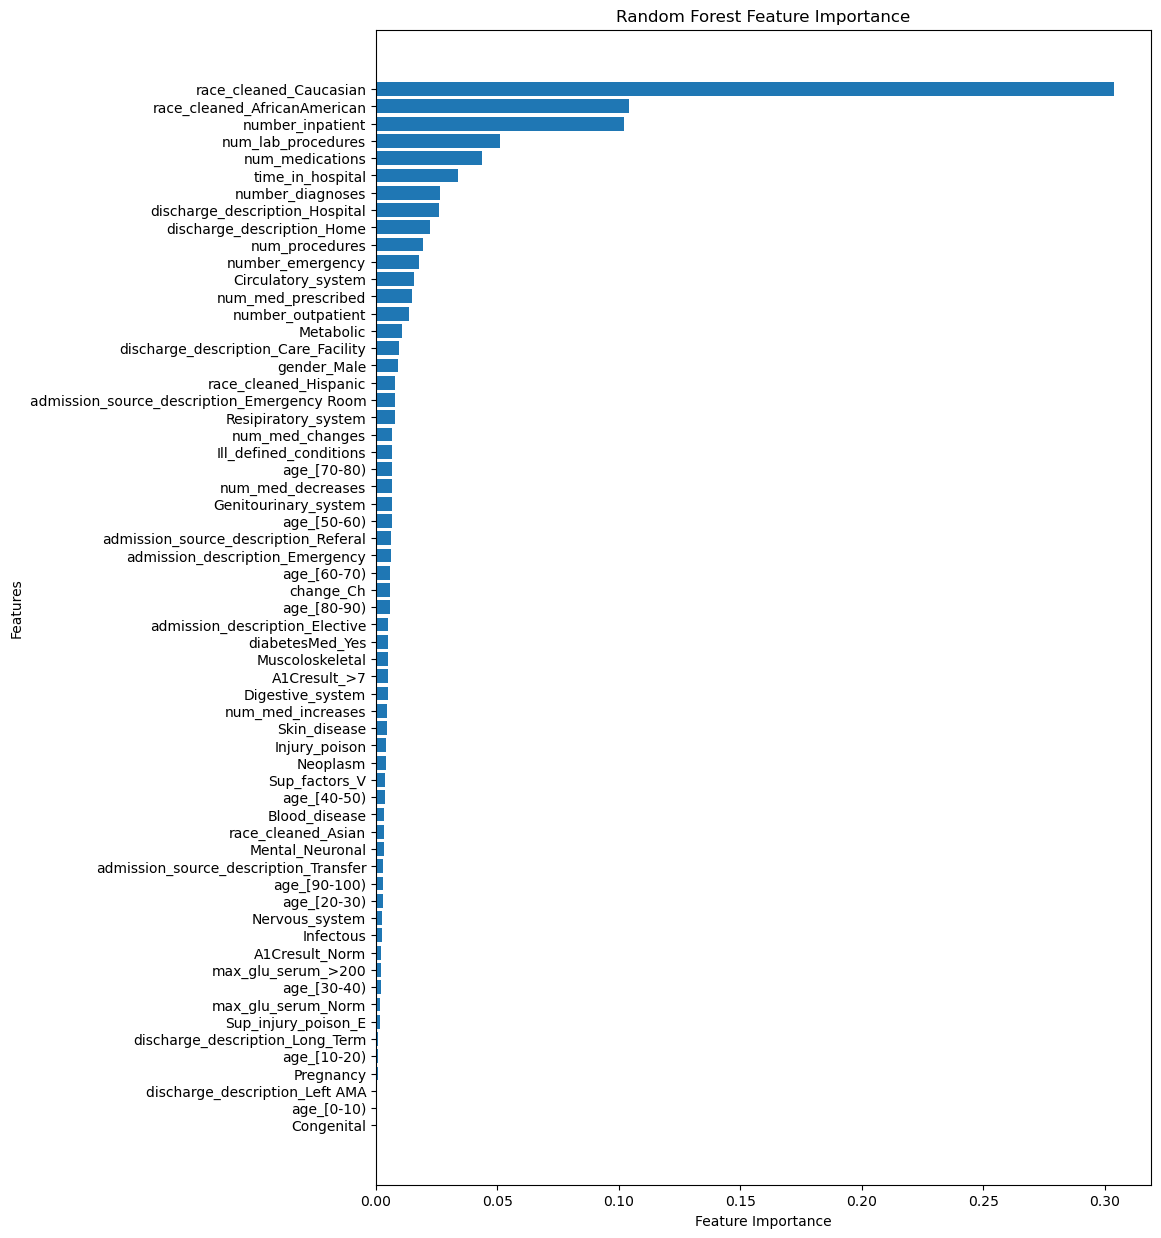

In [68]:
# Create a DataFrame for better visualization
feature_names = X_resampled.columns
importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': feature_importance_rf
})

# Sort by importance
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# Plot the feature importance for better visualization
plt.figure(figsize=(10, 15))
plt.barh(importance_df['Feature'], importance_df['Importance'])
plt.xlabel('Feature Importance')
plt.ylabel('Features')
plt.title('Random Forest Feature Importance')
plt.gca().invert_yaxis()  # Invert y-axis to display the most important features at the top
plt.show()

In [69]:
# Initialize the XGBClassifier
xgb_model = XGBClassifier(eval_metric='mlogloss', random_state=42, n_jobs=-1)

X_resampled.columns = X_resampled.columns.str.replace('>', '', regex=False)
X_resampled.columns = X_resampled.columns.str.replace('<', '', regex=False)
X_resampled.columns = X_resampled.columns.str.replace('[', '(', regex=False)

X_test.columns = X_test.columns.str.replace('>', '', regex=False)
X_test.columns = X_test.columns.str.replace('<', '', regex=False)
X_test.columns = X_test.columns.str.replace('[', '(', regex=False)

# Define the search space for hyperparameters
param_space = {
    'n_estimators': (50, 300),          
    'max_depth': (1, 30),    
    'learning_rate': (0.01, 0.2),
    'subsample': (0.1, 1.0),  
    'colsample_bytree': (0.1, 1.0),
    'gamma': (0, 1)  
}

# Initialize StratifiedGroupKFold for cross-validation
cv = StratifiedGroupKFold(n_splits=5)

# Initialize BayesSearchCV
bayes_search = BayesSearchCV(
    estimator=xgb_model, 
    search_spaces=param_space,
    n_iter=50,
    cv=cv, 
    scoring='balanced_accuracy', 
    random_state=42,
    n_jobs=-1
)

# Fit the Bayesian optimizer on the dataset (with grouped patients)
bayes_search.fit(X_resampled, y_resampled, groups=groups)

# Best hyperparameters from Bayesian optimization
print("Best parameters:", bayes_search.best_params_)

# Train the final model with the best hyperparameters on the entire dataset
best_model_xgb = bayes_search.best_estimator_
best_model_xgb.fit(X_resampled, y_resampled)

# Make predictions on the test set
y_pred = best_model_xgb.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")

# Generate the classification report
report_xgb = classification_report(y_test, y_pred, output_dict=True)

# Generate the confusion matrix
conf_matrix_xgb = confusion_matrix(y_test, y_pred)

# Get feature importance
feature_importance_xgb = best_model_xgb.feature_importances_

# XGB
xgb_probs = best_model_xgb.predict_proba(X_test)[:, 1]

# Random Forest ROC
xgb_fpr, xgb_tpr, xgb_thresholds = roc_curve(y_test, xgb_probs)
xgb_auc = roc_auc_score(y_test, rf_probs)

Best parameters: OrderedDict({'colsample_bytree': 0.19944192153143564, 'gamma': 0, 'learning_rate': 0.10030277720149516, 'max_depth': 1, 'n_estimators': 121, 'subsample': 0.18322659867490249})
Accuracy: 0.71


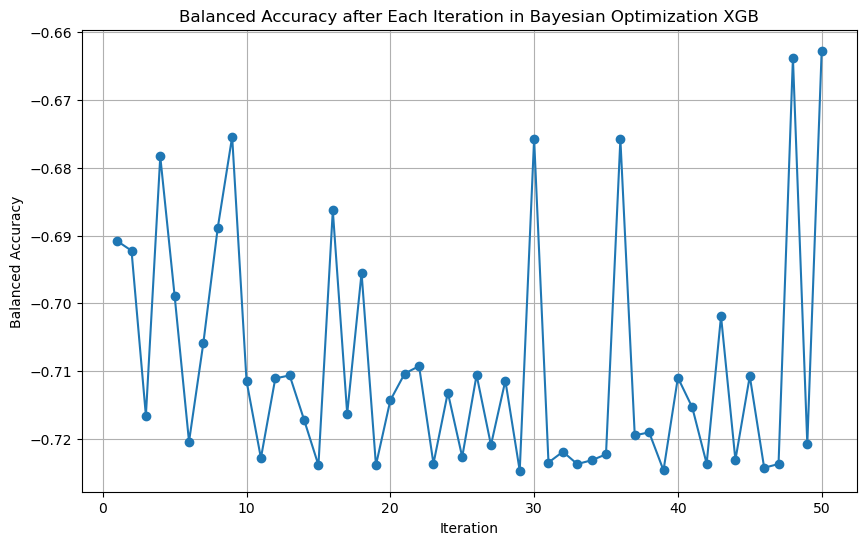

Best parameters: OrderedDict({'colsample_bytree': 0.19944192153143564, 'gamma': 0, 'learning_rate': 0.10030277720149516, 'max_depth': 1, 'n_estimators': 121, 'subsample': 0.18322659867490249})


In [71]:
errors_xgb = -bayes_search.cv_results_['mean_test_score']

# Plot the error after each iteration
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(errors_xgb) + 1), errors_xgb, marker='o')
plt.title('Balanced Accuracy after Each Iteration in Bayesian Optimization XGB')
plt.xlabel('Iteration')
plt.ylabel('Balanced Accuracy')
plt.grid(True)
plt.show()

# Best hyperparameters from Bayesian optimization
print("Best parameters:", bayes_search.best_params_)

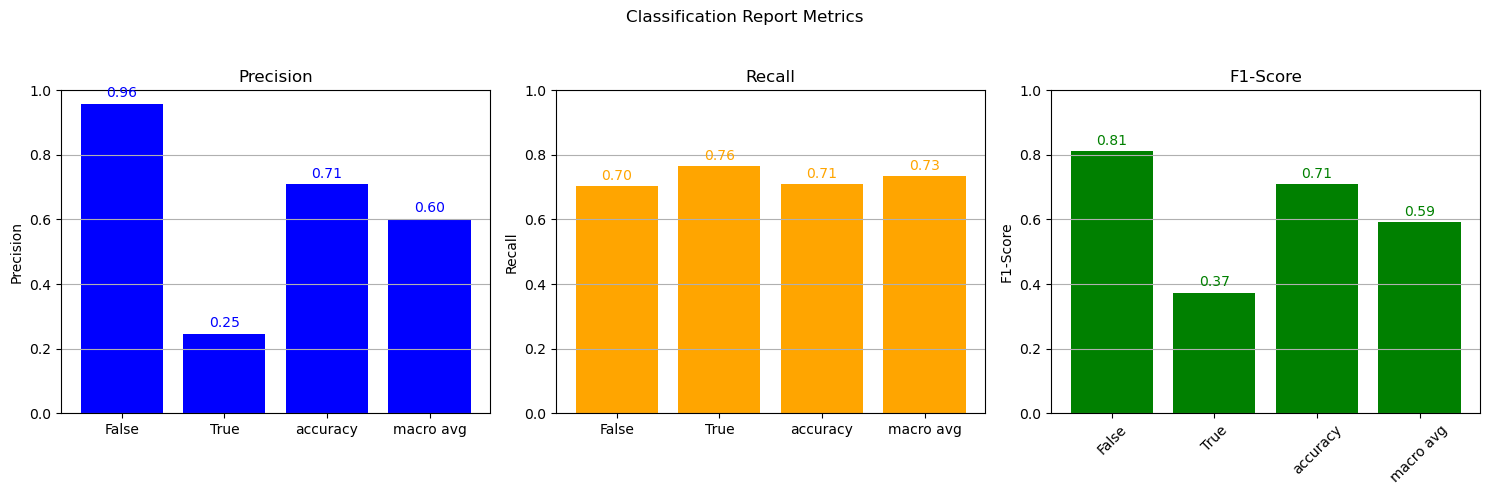

In [72]:
# Convert to DataFrame
report_df = pd.DataFrame(report_xgb).transpose()

# Dropping 'support' for clearer plots
report_df = report_df.drop(columns=['support'])

# Set class names for better readability
class_names = report_df.index[:-1]  # Exclude 'accuracy' row

# Plotting
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15, 5))

# Bar plot for Precision
axes[0].bar(class_names, report_df['precision'][:-1], color='blue')
axes[0].set_title('Precision')
axes[0].set_ylim(0, 1)
axes[0].set_ylabel('Precision')
axes[0].grid(axis='y')

# Adding value labels
for i, v in enumerate(report_df['precision'][:-1]):
    axes[0].text(i, v + 0.02, f"{v:.2f}", ha='center', color='blue')

# Bar plot for Recall
axes[1].bar(class_names, report_df['recall'][:-1], color='orange')
axes[1].set_title('Recall')
axes[1].set_ylim(0, 1)
axes[1].set_ylabel('Recall')
axes[1].grid(axis='y')

# Adding value labels
for i, v in enumerate(report_df['recall'][:-1]):
    axes[1].text(i, v + 0.02, f"{v:.2f}", ha='center', color='orange')

# Bar plot for F1-score
axes[2].bar(class_names, report_df['f1-score'][:-1], color='green')
axes[2].set_title('F1-Score')
axes[2].set_ylim(0, 1)
axes[2].set_ylabel('F1-Score')
axes[2].grid(axis='y')

# Adding value labels
for i, v in enumerate(report_df['f1-score'][:-1]):
    axes[2].text(i, v + 0.02, f"{v:.2f}", ha='center', color='green')

plt.suptitle('Classification Report Metrics')
plt.xticks(rotation=45)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

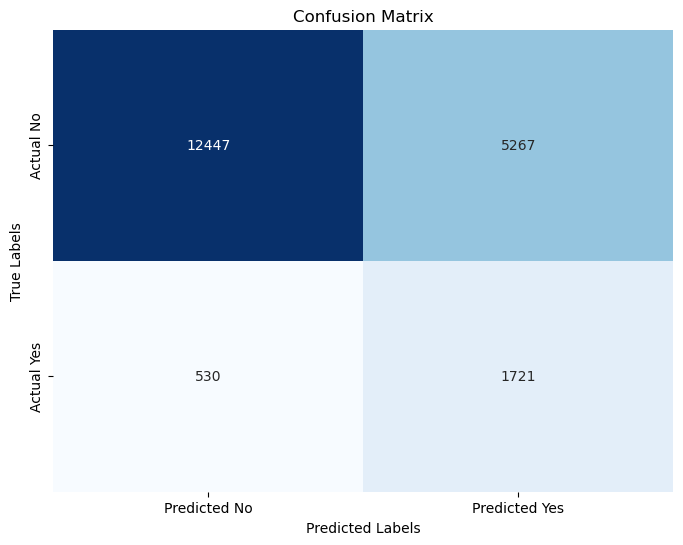

In [73]:
# Create a heatmap using seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_xgb, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Predicted No', 'Predicted Yes'],
            yticklabels=['Actual No', 'Actual Yes'])

# Add labels, title, and axes ticks
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

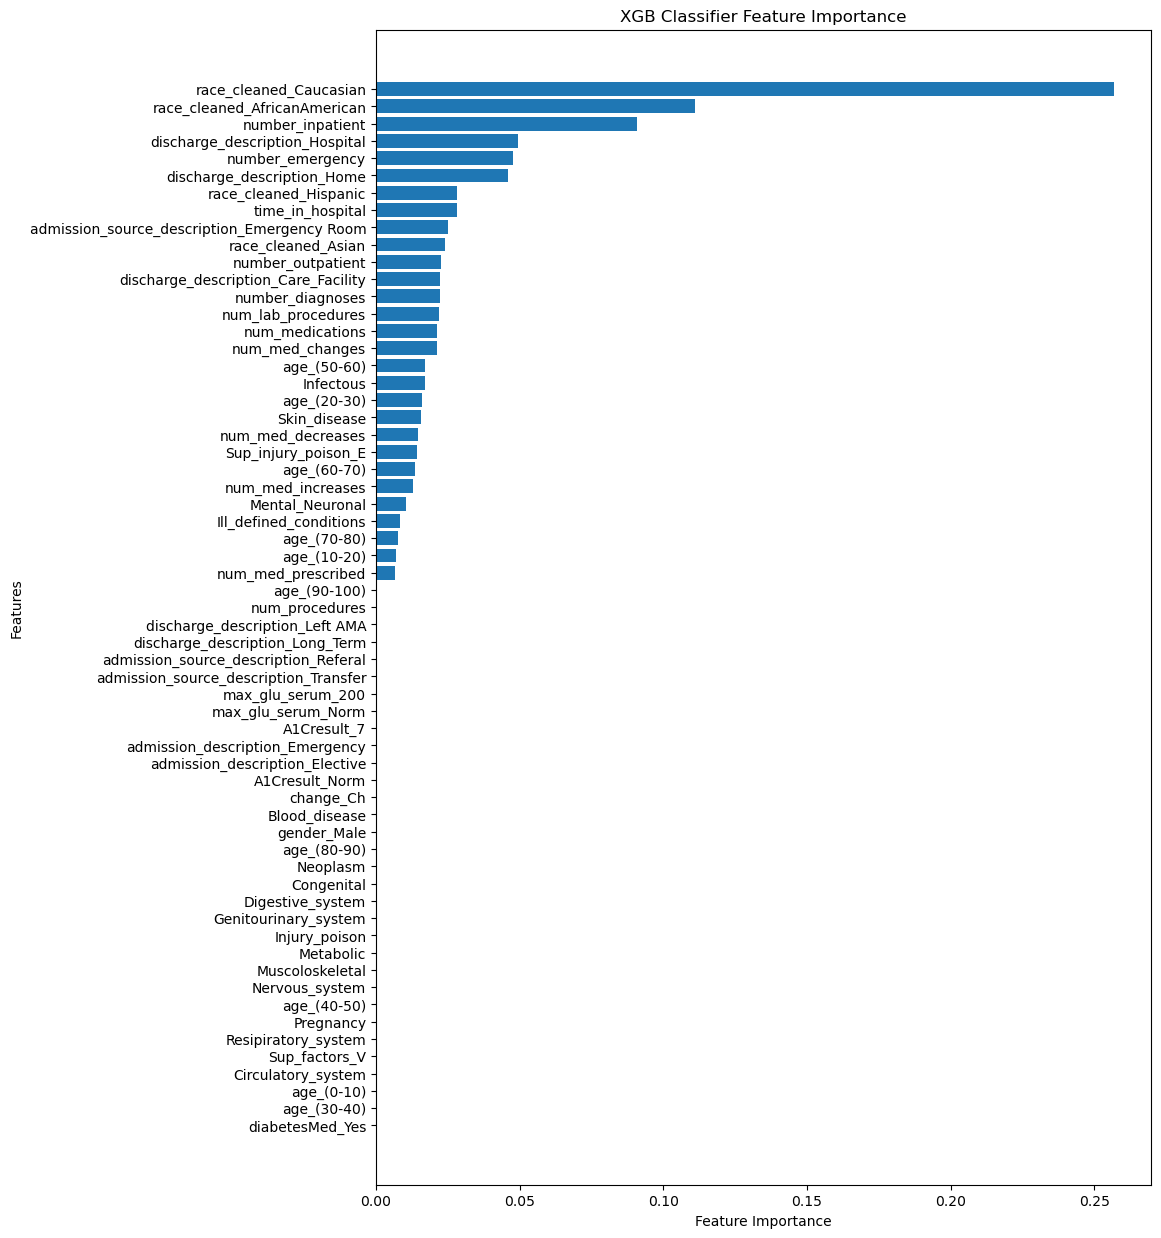

In [74]:
# Create a DataFrame for better visualization
feature_names = X_resampled.columns
importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': feature_importance_xgb
})

# Sort by importance
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# Plot the feature importance for better visualization
plt.figure(figsize=(10, 15))
plt.barh(importance_df['Feature'], importance_df['Importance'])
plt.xlabel('Feature Importance')
plt.ylabel('Features')
plt.title('XGB Classifier Feature Importance')
plt.gca().invert_yaxis()  # Invert y-axis to display the most important features at the top
plt.show()

In [75]:
# Initialize the Cat Boost Classifier
catboost_model = CatBoostClassifier(random_state=42, verbose=0) #task_type="GPU", devices='0')

# Define the search space for hyperparameters
param_space = {
    'iterations': (100, 1000),                
    'depth': (2, 10),                          
    'learning_rate': (1e-5, 0.5, 'log-uniform'),  
    'l2_leaf_reg': (1e-5, 10, 'log-uniform'), 
    'loss_function': ['Logloss'], 
}

# Initialize StratifiedGroupKFold for cross-validation
cv = StratifiedGroupKFold(n_splits=5)

# Initialize BayesSearchCV
bayes_search = BayesSearchCV(
    estimator=catboost_model, 
    search_spaces=param_space,
    n_iter=50,
    cv=cv, 
    scoring='balanced_accuracy', 
    random_state=42,
    n_jobs=-1
)

# Fit the Bayesian optimizer on the dataset (with grouped patients)
bayes_search.fit(X_resampled, y_resampled, groups=groups)

# Best hyperparameters from Bayesian optimization
print("Best parameters:", bayes_search.best_params_)

# Train the final model with the best hyperparameters on the entire dataset
best_model_cat = bayes_search.best_estimator_
best_model_cat.fit(X_resampled, y_resampled)

# Make predictions on the test set
y_pred = best_model_cat.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")

# Generate the classification report
report_cat = classification_report(y_test, y_pred, output_dict=True)

# Generate the confusion matrix
conf_matrix_cat = confusion_matrix(y_test, y_pred)

# Get feature importance
feature_importance_cat = best_model_cat.feature_importances_

# Cat Boost
cat_probs = best_model_cat.predict_proba(X_test)[:, 1]

# Random Forest ROC
cat_fpr, cat_tpr, cat_thresholds = roc_curve(y_test, cat_probs)
cat_auc = roc_auc_score(y_test, rf_probs)

Best parameters: OrderedDict({'depth': 10, 'iterations': 1000, 'l2_leaf_reg': 8.463375449561262, 'learning_rate': 0.0028038039549249877, 'loss_function': 'Logloss'})
Accuracy: 0.71


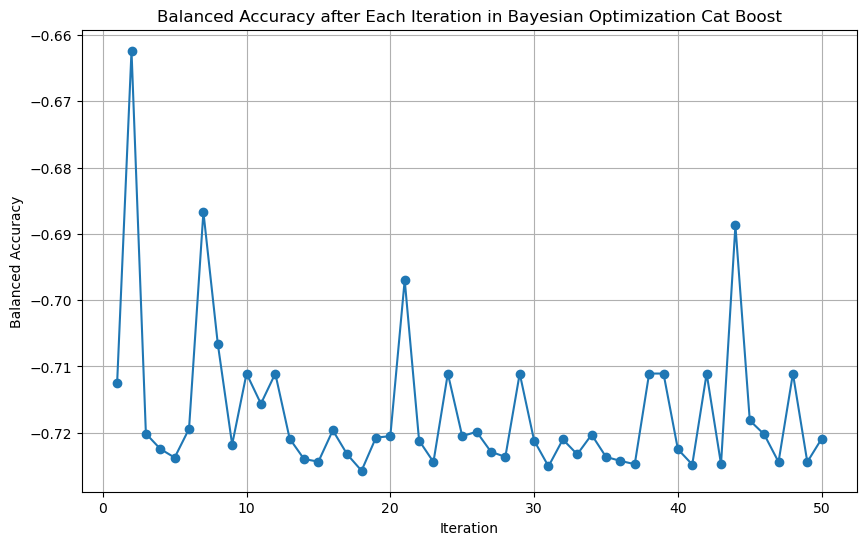

Best parameters: OrderedDict({'depth': 10, 'iterations': 1000, 'l2_leaf_reg': 8.463375449561262, 'learning_rate': 0.0028038039549249877, 'loss_function': 'Logloss'})


In [100]:
errors_cat = -bayes_search.cv_results_['mean_test_score']

# Plot the error after each iteration
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(errors_cat) + 1), errors_cat, marker='o')
plt.title('Balanced Accuracy after Each Iteration in Bayesian Optimization Cat Boost')
plt.xlabel('Iteration')
plt.ylabel('Balanced Accuracy')
plt.grid(True)
plt.show()

# Best hyperparameters from Bayesian optimization
print("Best parameters:", bayes_search.best_params_)

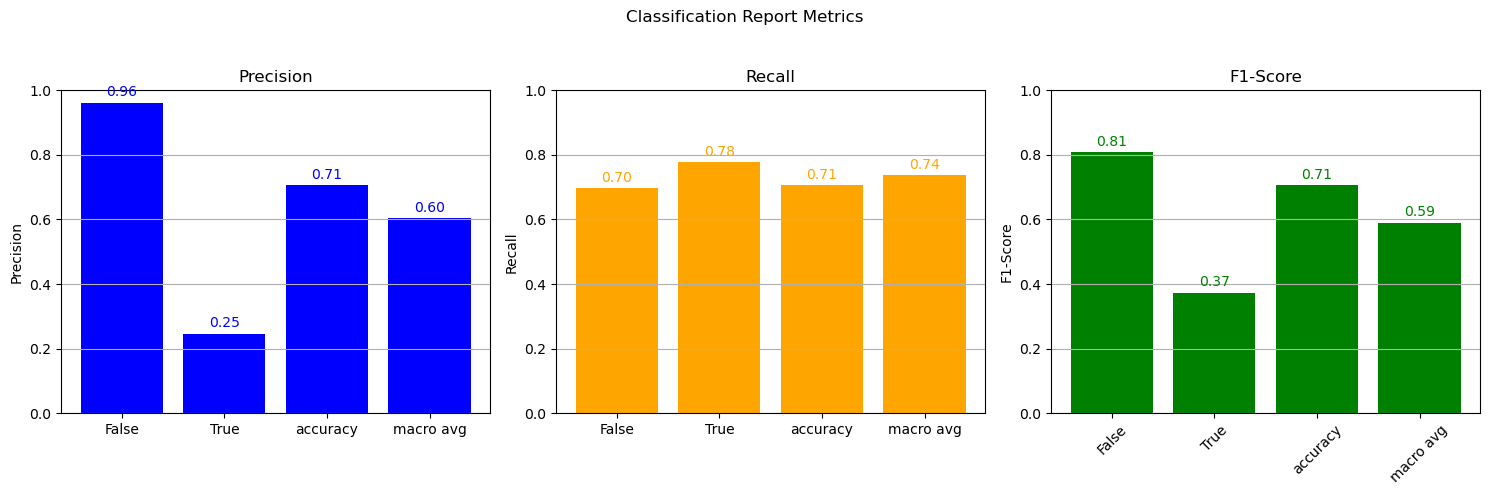

In [77]:
# Convert to DataFrame
report_df = pd.DataFrame(report_cat).transpose()

# Dropping 'support' for clearer plots
report_df = report_df.drop(columns=['support'])

# Set class names for better readability
class_names = report_df.index[:-1]  # Exclude 'accuracy' row

# Plotting
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15, 5))

# Bar plot for Precision
axes[0].bar(class_names, report_df['precision'][:-1], color='blue')
axes[0].set_title('Precision')
axes[0].set_ylim(0, 1)
axes[0].set_ylabel('Precision')
axes[0].grid(axis='y')

# Adding value labels
for i, v in enumerate(report_df['precision'][:-1]):
    axes[0].text(i, v + 0.02, f"{v:.2f}", ha='center', color='blue')

# Bar plot for Recall
axes[1].bar(class_names, report_df['recall'][:-1], color='orange')
axes[1].set_title('Recall')
axes[1].set_ylim(0, 1)
axes[1].set_ylabel('Recall')
axes[1].grid(axis='y')

# Adding value labels
for i, v in enumerate(report_df['recall'][:-1]):
    axes[1].text(i, v + 0.02, f"{v:.2f}", ha='center', color='orange')

# Bar plot for F1-score
axes[2].bar(class_names, report_df['f1-score'][:-1], color='green')
axes[2].set_title('F1-Score')
axes[2].set_ylim(0, 1)
axes[2].set_ylabel('F1-Score')
axes[2].grid(axis='y')

# Adding value labels
for i, v in enumerate(report_df['f1-score'][:-1]):
    axes[2].text(i, v + 0.02, f"{v:.2f}", ha='center', color='green')


plt.suptitle('Classification Report Metrics')
plt.xticks(rotation=45)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

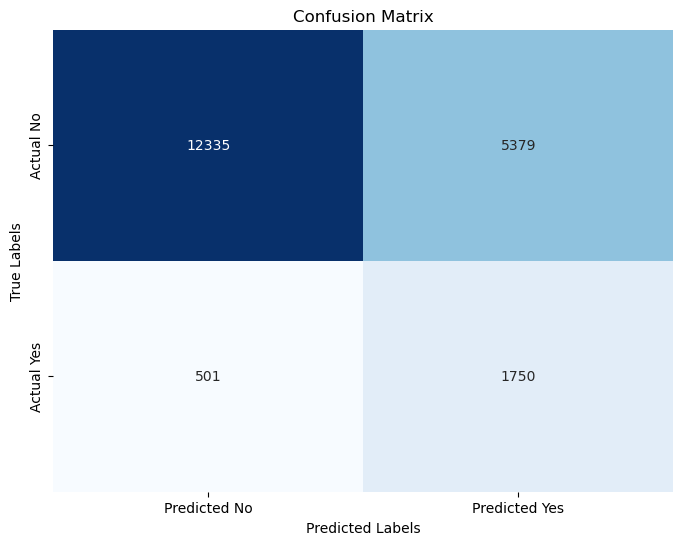

In [78]:
# Create a heatmap using seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_cat, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Predicted No', 'Predicted Yes'],
            yticklabels=['Actual No', 'Actual Yes'])

# Add labels, title, and axes ticks
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

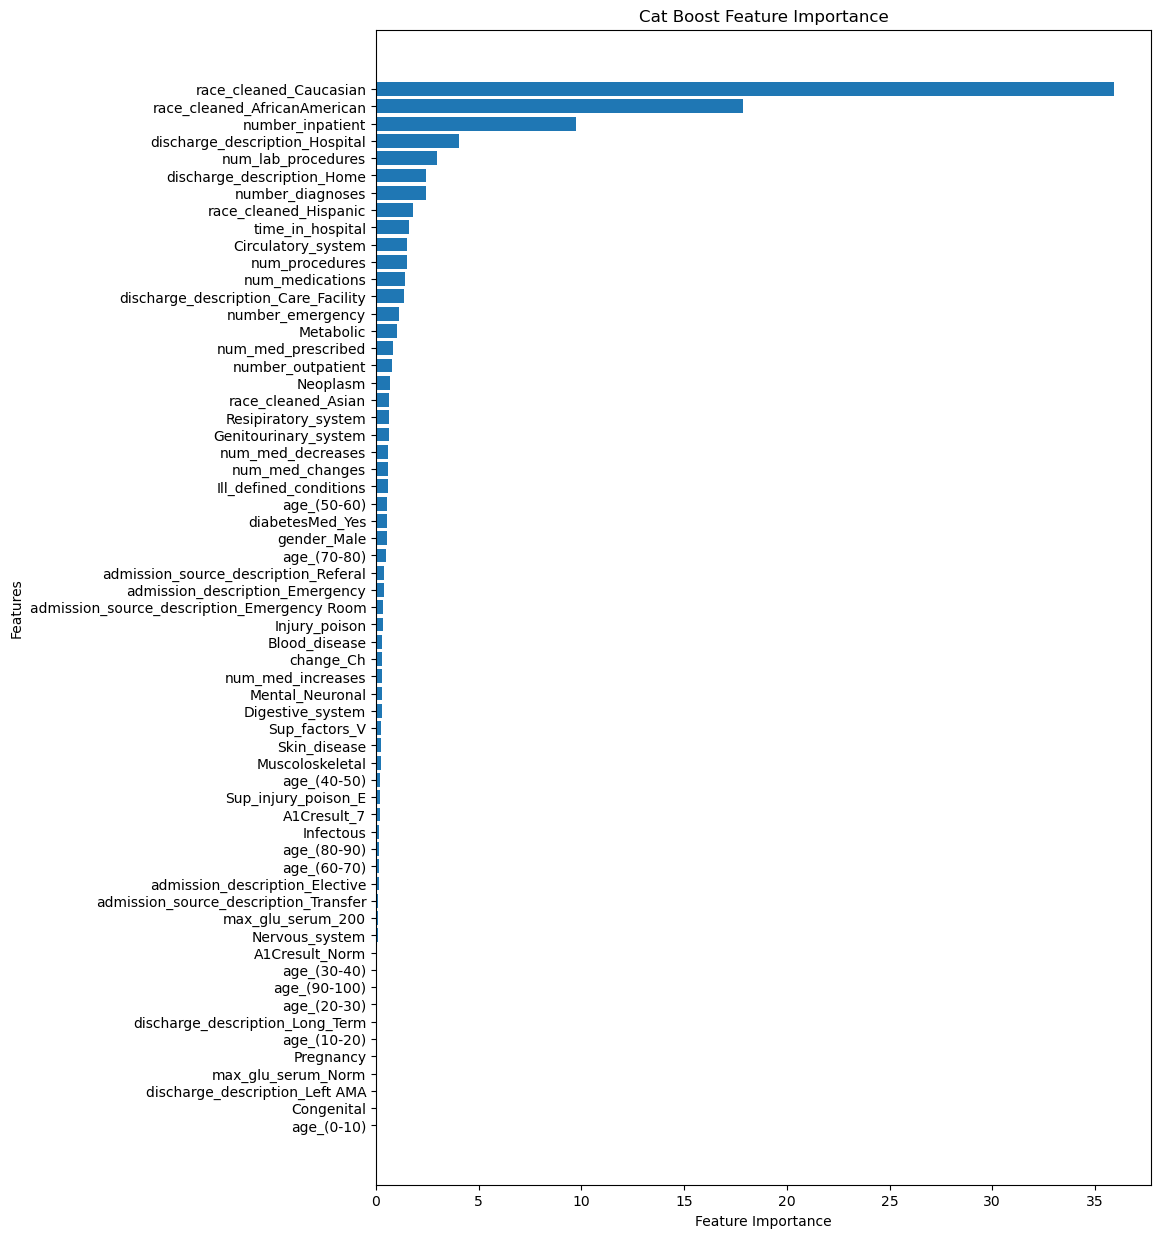

In [79]:
# Create a DataFrame for better visualization
feature_names = X_resampled.columns
importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': feature_importance_cat
})

# Sort by importance
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# Plot the feature importance for better visualization
plt.figure(figsize=(10, 15))
plt.barh(importance_df['Feature'], importance_df['Importance'])
plt.xlabel('Feature Importance')
plt.ylabel('Features')
plt.title('Cat Boost Feature Importance')
plt.gca().invert_yaxis()  # Invert y-axis to display the most important features at the top
plt.show()

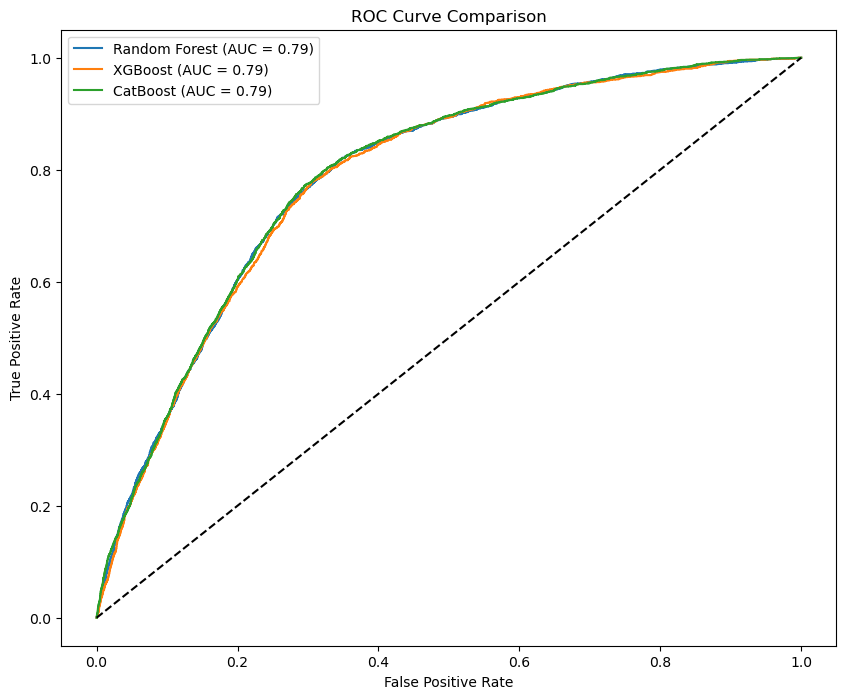

In [80]:
#ROC comparison

plt.figure(figsize=(10, 8))

# Random Forest
plt.plot(rf_fpr, rf_tpr, label=f"Random Forest (AUC = {rf_auc:.2f})")

# XGBoost
plt.plot(xgb_fpr, xgb_tpr, label=f"XGBoost (AUC = {xgb_auc:.2f})")

# CatBoost
plt.plot(cat_fpr, cat_tpr, label=f"CatBoost (AUC = {cat_auc:.2f})")

# Plot settings
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve Comparison')
plt.legend(loc='best')

plt.show()

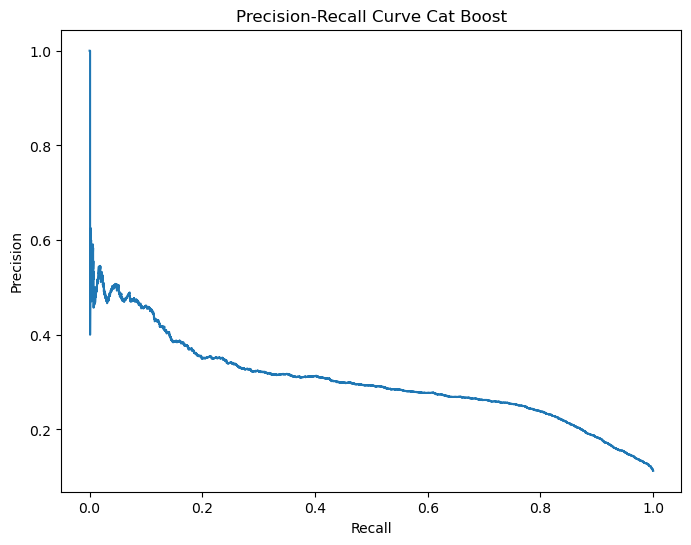

In [81]:
#Precision-Recall Curve
precision, recall, thresholds = precision_recall_curve(y_test, cat_probs)

# Plot the precision-recall curve
plt.figure(figsize=(8, 6))
plt.plot(recall, precision)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve Cat Boost')
plt.show()

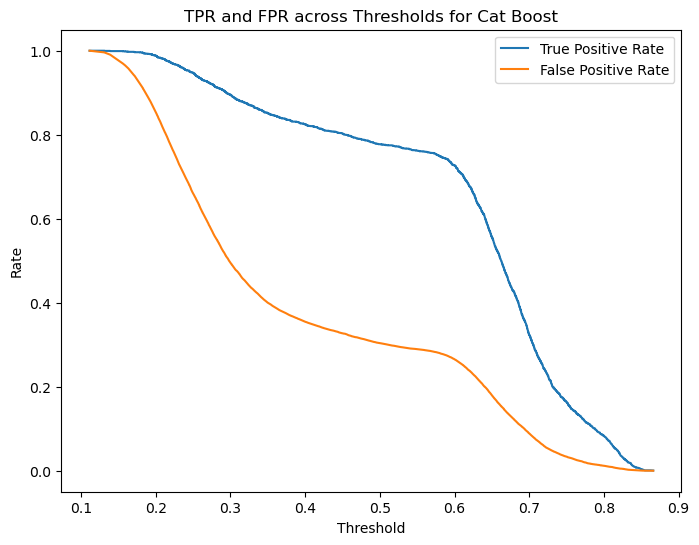

Optimal Threshold for Cat Boost: 0.5163608894969418


In [82]:
#TPR and FPR across Thresholds for Cat Boost

plt.figure(figsize=(8, 6))
plt.plot(cat_thresholds, cat_tpr, label='True Positive Rate')
plt.plot(cat_thresholds, cat_fpr, label='False Positive Rate')
plt.xlabel('Threshold')
plt.ylabel('Rate')
plt.title('TPR and FPR across Thresholds for Cat Boost')
plt.legend()
plt.show()

youden_index = cat_tpr - cat_fpr
optimal_threshold_index = np.argmax(youden_index)
optimal_threshold = cat_thresholds[optimal_threshold_index]


print(f"Optimal Threshold for Cat Boost: {optimal_threshold}")

In [83]:
display(Markdown("""
# Conclusions and recomendations

##### The best model is the Cat Boost classifier with an ROC of 0.79 and accuracy of 0.71. This model could help doctors by providing a data driven prediction of the likelyhood a patient might come back before 30 days. 

##### The main issue of the model is that it has a low precision, as it predicts that a patient might come back within 30 days when in reality they don't. The outcome of this is:

- **Increase the workload of the doctor:** Doctor is more careful by ordering more test or prolonging the stay of the patient.
- **Waste the patient´s time and money, as well as worry them:** They stay longer than needed and may think something is wrong 
- **Waste hospital resources:** Using staff and equipment in a healthy patient.

##### The good thing about the model is the high recall, meaning there are low false negatives. This is good for the hospital as they do not wrongly discharge a patient that could come back before 30 days.

##### The model can be further improved with the following:

- **Classification thresholds:** Changing the standard threshold of 0.5 can increase/decrease precision and recall of the model
- **Cost sensitive learning:** Introduce a custom error function based on placing more importance on recall / precision
- **New data:** Additional data (rows) could help the model.
- **Feature engineering:** Additional features (columns) could better explain why a patient may or may not come back before 30 days. 

"""))


# Conclusions and recomendations

##### The best model is the Cat Boost classifier with an ROC of 0.79 and accuracy of 0.71. This model could help doctors by providing a data driven prediction of the likelyhood a patient might come back before 30 days. 

##### The main issue of the model is that it has a low precision, as it predicts that a patient might come back within 30 days when in reality they don't. The outcome of this is:

- **Increase the workload of the doctor:** Doctor is more careful by ordering more test or prolonging the stay of the patient.
- **Waste the patient´s time and money, as well as worry them:** They stay longer than needed and may think something is wrong 
- **Waste hospital resources:** Using staff and equipment in a healthy patient.

##### The good thing about the model is the high recall, meaning there are low false negatives. This is good for the hospital as they do not wrongly discharge a patient that could come back before 30 days.

##### The model can be further improved with the following:

- **Classification thresholds:** Changing the standard threshold of 0.5 can increase/decrease precision and recall of the model
- **Cost sensitive learning:** Introduce a custom error function based on placing more importance on recall / precision
- **New data:** Additional data (rows) could help the model.
- **Feature engineering:** Additional features (columns) could better explain why a patient may or may not come back before 30 days. 

